### ***Libraries***

In [ ]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import torch.optim as optim
import torchvision
import torch.nn as nn
import seaborn as sns
import pickle
from torchvision.utils import save_image, make_grid
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler, UNet2DModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00


Google Drive and GPU connection

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
if torch.cuda.is_available():
  print("GPU is available!")
else:
  print("GPU is not available.")

GPU is available!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

### ***Functions***

In [ ]:

def show_images(x):
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

def padding_zero(x):
    x = np.pad(x,((0,1),(0,1)),constant_values = 0)
    x =  np.pad(x, 4 ,constant_values = 0)
    return x

def binary_threshold(batch, threshold=0.5):

    # Apply the threshold to the batch
    binary_batch = (batch > threshold).float()

    return binary_batch

def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.detach().cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

def add_noise(matrix, noise_level=0.5):
    """
    Add random noise to a matrix.

    Parameters:
    - matrix: Input matrix
    - noise_level: The magnitude of the added noise (default is 0.01)

    Returns:
    - Matrix with added noise
    """
    noise = np.random.normal(0, noise_level, matrix.shape)
    noisy_matrix = matrix + noise
    return noisy_matrix

def print_matrix(noise, matrix, pattern_pred):
    img1_np = noise.detach().cpu().numpy()
    img2_np = matrix.permute(0, 2, 3, 1).detach().cpu().numpy()  # (bs, 32, 32, 3)
    img3_np = pattern_pred.detach().cpu().numpy()

    # Create a figure with subplots
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))

    # First subplot: img1
    axs[0].imshow(img1_np[0, 0], cmap='gray')  # Display the first image in the batch (assuming single channel)
    axs[0].set_title('Prediction')
    axs[0].axis('off')

    # Second subplot: img2
    axs[1].imshow(img2_np[0])  # Display the first image in the batch with RGB channels
    axs[1].set_title('Matrix - condition')
    axs[1].axis('off')

    # Third subplot: img3
    axs[2].imshow(img3_np[0, 0], cmap='gray')  # Display the first image in the batch (assuming single channel)
    axs[2].set_title('Pattern')
    axs[2].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()



---

### ***Data loading***

Upload the data to the google drive, and change the file_path accordingly

In [ ]:
sample_data = []

for i in range(1,25001):
    file_path = f'/content/drive/MyDrive/Deep learning/Final Project/Si_MS_Scat_samp_{i}.mat'
    mat_data = sio.loadmat(file_path)

    # Extract parameters from the loaded MATLAB file
    Rm_data = np.array(mat_data['Rm']).flatten()
    Tm_data = np.array(mat_data['Tm']).flatten()
    h_data = np.tile(np.array(mat_data['h']),(32, 32)).flatten().astype(np.float32)
    xx_data = np.array(mat_data['xx']).flatten()

    # Store the parameters in a dictionary or list
    sample_dict = {
        'Sample': f'Si_MS_Scat_samp_{i}',
        'h_data': h_data,
        'xx_data': xx_data,
        'Rm_data': Rm_data,
        'Tm_data': Tm_data
    }
    sample_data.append(sample_dict)

dataset_df = pd.DataFrame(sample_data)
dataset_df.to_pickle('/content/drive/MyDrive/Deep learning/Final Project/dataset_df.pkl')

Change the path accordingly and upload the dataframe

In [ ]:
path = '/content/drive/MyDrive/dataset_df.pkl'
dataset_df = pd.read_pickle(path)
dataset_df.head()

,Sample,h_data,xx_data,Rm_data,Tm_data
0,Si_MS_Scat_samp_1,"[482.0, 482.0, 482.0, 482.0, 482.0, 482.0, 482...","[0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Si_MS_Scat_samp_2,"[199.0, 199.0, 199.0, 199.0, 199.0, 199.0, 199...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Si_MS_Scat_samp_3,"[295.0, 295.0, 295.0, 295.0, 295.0, 295.0, 295...","[0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Si_MS_Scat_samp_4,"[397.0, 397.0, 397.0, 397.0, 397.0, 397.0, 397...","[0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Si_MS_Scat_samp_5,"[286.0, 286.0, 286.0, 286.0, 286.0, 286.0, 286...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


---

### ***Data processing***

In [ ]:
sample_data = []

# h normalization
flattened_data = [value for sublist in dataset_df['h_data'] for value in sublist]
max_value = max(flattened_data)
min_value = min(flattened_data)
dataset_df['h_data'] = (dataset_df['h_data'] - min_value) / (max_value - min_value)

for i in range(0,25000):
    rm = torch.tensor(dataset_df.at[dataset_df.index[i],'Rm_data'])
    tm = torch.tensor(dataset_df.at[dataset_df.index[i],'Tm_data'])
    h = torch.tensor(dataset_df.at[dataset_df.index[i],'h_data'])
    # Get the shape of the Rm_data matrix
    rm_data_shape = dataset_df.at[dataset_df.index[i], 'Rm_data'].shape
    # Create a ones matrix with the same shape as the Rm_data matrix
    ones_matrix = torch.ones(rm_data_shape)
    h = np.dot(ones_matrix,dataset_df['h_data'][i][0])
    h = torch.tensor(h).view(23, 23)
    xx_data = torch.tensor(dataset_df.at[dataset_df.index[i],'xx_data']).view(10, 10)


    # Assuming rm, tm, h are already defined tensors with shape (23, 23)
    rm_padding = torch.tensor(padding_zero(rm.view(23, 23)))
    tm_padding = torch.tensor(padding_zero(tm.view(23, 23)))
    h_padding = torch.tensor(padding_zero(h))
    xx_data_padding = torch.tensor(np.pad(xx_data, 11 ,constant_values = 0)).unsqueeze(0)

    # Combine the matrices into a single tensor
    combined_matrix = torch.stack([rm_padding, tm_padding,h_padding], dim=0)

    # Store the parameters in a dictionary or list
    sample_dict = {
        'sample number': f'{i}',
        'matrix': combined_matrix,
        'xx_data': xx_data_padding
    }
    sample_data.append(sample_dict)

dataset_df = pd.DataFrame(sample_data)

In [ ]:
dataset_df.head()

,sample number,matrix,xx_data
0,0,"[[[tensor(0., dtype=torch.float64), tensor(0.,...","[[[tensor(0, dtype=torch.uint8), tensor(0, dty..."
1,1,"[[[tensor(0., dtype=torch.float64), tensor(0.,...","[[[tensor(0, dtype=torch.uint8), tensor(0, dty..."
2,2,"[[[tensor(0., dtype=torch.float64), tensor(0.,...","[[[tensor(0, dtype=torch.uint8), tensor(0, dty..."
3,3,"[[[tensor(0., dtype=torch.float64), tensor(0.,...","[[[tensor(0, dtype=torch.uint8), tensor(0, dty..."
4,4,"[[[tensor(0., dtype=torch.float64), tensor(0.,...","[[[tensor(0, dtype=torch.uint8), tensor(0, dty..."


In [ ]:
# Convert the 'matrix' column to a list of tensors
matrix_tensors = list(dataset_df['matrix'])

# Calculate mean and std for normalization
mean_value = torch.stack(matrix_tensors).mean(dim=(0, 2, 3))
std_value = torch.stack(matrix_tensors).std(dim=(0, 2, 3))

# Define normalization transformation
normalize = transforms.Normalize(mean=mean_value.tolist(), std=std_value.tolist())

# Apply normalization to each tensor in the 'matrix' column
for i in range(len(dataset_df)):
    matrix_tensor = dataset_df['matrix'][i]
    normalized_matrix = normalize(matrix_tensor)
    dataset_df.at[i, 'matrix'] = normalized_matrix

The light matrix:

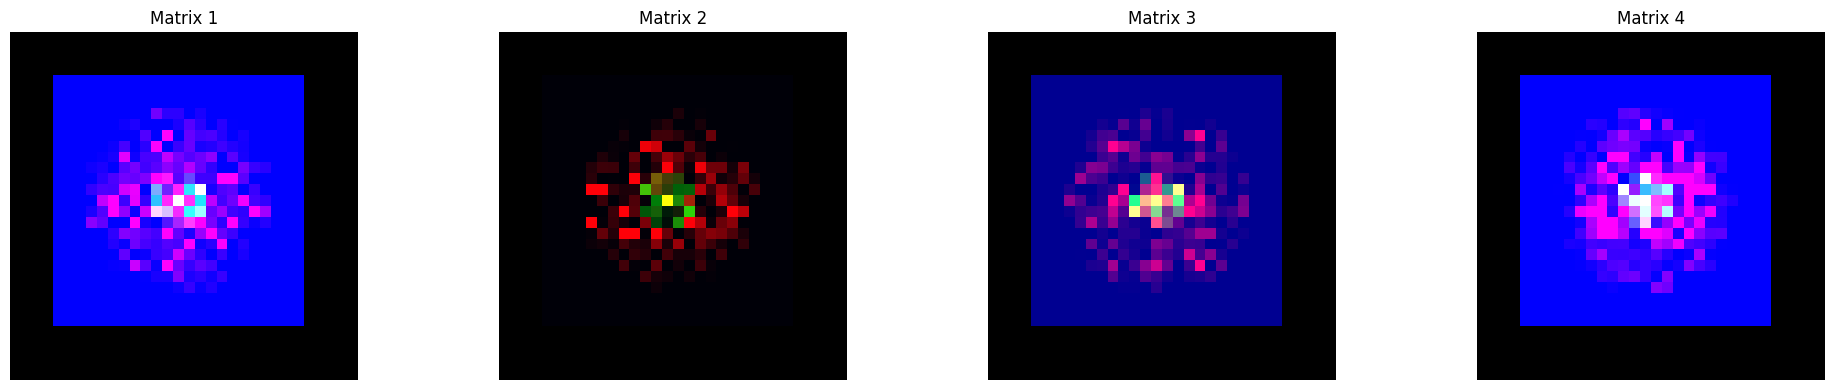

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, ax in enumerate(axs):
    img = dataset_df['matrix'][i]
    img_np = img.permute(1, 2, 0).numpy()
    img_np = img_np.clip(0, 1)

    ax.imshow(img_np)
    ax.set_title('Matrix ' + str(i+1))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
dataset_df['matrix'][0].shape

torch.Size([3, 32, 32])

In [ ]:
dataset_df['xx_data'][0].shape

torch.Size([1, 32, 32])

The pattern matrix:

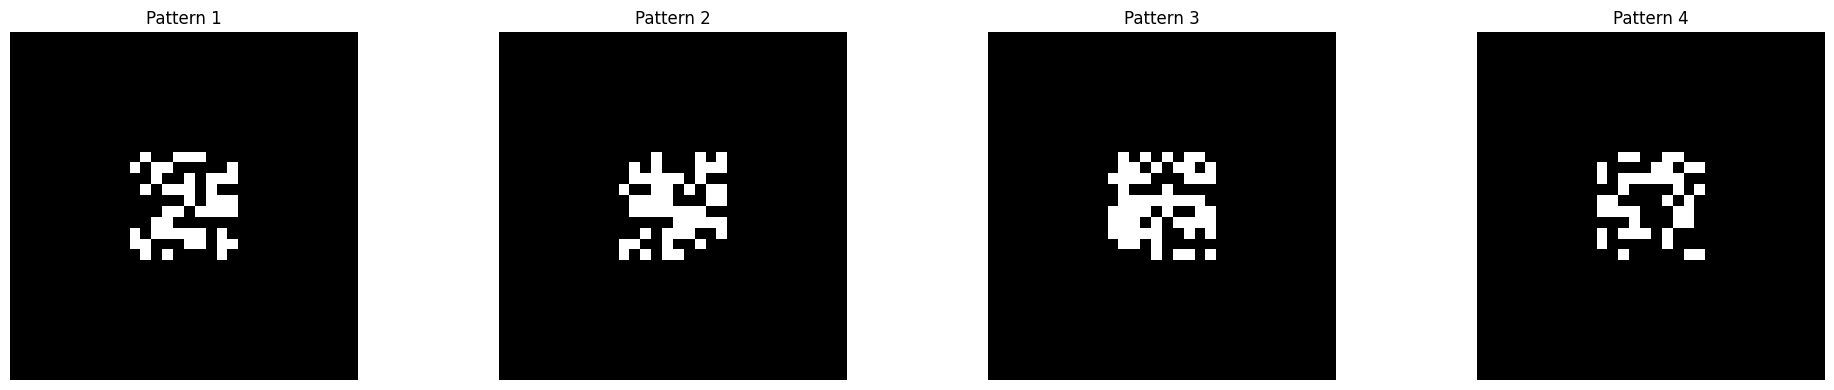

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, ax in enumerate(axs):
    img = dataset_df['xx_data'][i][0]

    ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Pattern '+ str(i+1))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
dataset_df['xx_data'][0].shape

torch.Size([1, 32, 32])

In [ ]:
matrix = dataset_df["matrix"].tolist()  # Convert to a list of tensors
xx_data = dataset_df["xx_data"].tolist()  # Convert to a list of tensors

In [ ]:
# Convert lists of tensors to PyTorch tensors
matrix = torch.stack(matrix)
xx_data = [x.view(1, 32, 32) for x in xx_data]
xx_data = torch.stack(xx_data)

Dividing the training data and test data:

In [ ]:
matrix_train, matrix_test, xx_data_train, xx_data_test = train_test_split(matrix, xx_data, test_size=0.08, random_state=42)
print('matrix train shape:', matrix_train.shape)
print('xx_data train shape:', xx_data_train.shape)
print('matrix test shape:', matrix_test.shape)
print('xx_data test shape:', xx_data_test.shape)

matrix train shape: torch.Size([23000, 3, 32, 32])
xx_data train shape: torch.Size([23000, 1, 32, 32])
matrix test shape: torch.Size([2000, 3, 32, 32])
xx_data test shape: torch.Size([2000, 1, 32, 32])


In [ ]:
batch_size = 20
train_dataset = TensorDataset(matrix_train.to(torch.float32),xx_data_train.to(torch.float32))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(matrix_test.to(torch.float32),xx_data_test.to(torch.float32))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

X shape: torch.Size([8, 1, 32, 32])


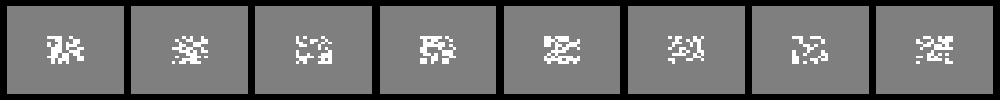

In [ ]:
xb = next(iter(train_loader))[1].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((100 * 10, 100), resample=Image.NEAREST)

---

### ***Define the Scheduler***


In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

Noisy X shape torch.Size([8, 1, 32, 32])


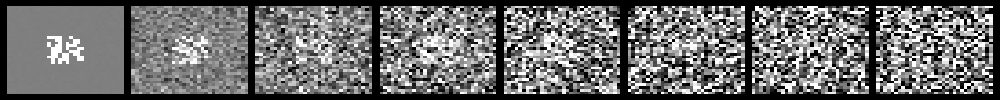

In [ ]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((100 * 10, 100), resample=Image.NEAREST)

### ***Define the Model***


In [ ]:
class ClassConditionedUnet(nn.Module):
  def __init__(self):
    super().__init__()

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size= 32,           # the target image resolution
        in_channels= 1 + 3, # Additional input channels for class cond.
        out_channels= 1,           # the number of output channels
        layers_per_block= 2,       # how many ResNet layers to use per UNet block
        block_out_channels= (32 ,64 ,64,128),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "DownBlock2D",
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",
             "UpBlock2D",
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, matrix):

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, matrix), 1) # (bs, 4, 32, 32)

    # Feed this to the unet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 32, 32)

### ***Create a Training Loop***
The following batches were run:
16, 20, 24, 32

In [ ]:
model = ClassConditionedUnet().to(device)

# Define the batch size and number of epochs
batch_size = 32
n_epochs = 50

# Create lists for loss functions and learning rates
loss_functions = [nn.MSELoss(), nn.L1Loss(), nn.HuberLoss()]
learning_rates = [2e-1, 1e-2, 4e-3, 3e-4]

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Loss Function', 'Learning Rate', 'Final Loss', 'batch size'])

# The training loop for different combinations of loss functions and learning rates
for loss_fn in loss_functions:
    for lr in learning_rates:
        # Create a new model and optimizer for each combination
        model = ClassConditionedUnet().to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        # Keeping a record of the losses for later viewing
        losses = []

        # The training loop
        for epoch in range(n_epochs):
            for matrix, pattern in tqdm(train_loader):

                # Get some data and prepare the corrupted version
                matrix = matrix.to(device) * 2 - 1
                pattern = pattern.to(device)
                noise = torch.randn_like(pattern)
                timesteps = torch.randint(0, 999, (pattern.shape[0],)).long().to(device)
                noisy_step = noise_scheduler.add_noise(pattern, noise, timesteps)

                # Get the model prediction
                pred = model(noisy_step, timesteps, matrix.long())

                # Calculate the loss
                loss = loss_fn(pred, noise)

                # Backprop and update the params:
                opt.zero_grad()
                loss.backward()
                opt.step()

                # Store the loss for later
                losses.append(loss.item())

            # Print our the average of the last 100 loss values to get an idea of progress:
            print(f'Finished epoch {epoch}')

        # Store the final loss in the DataFrame
        final_loss = losses[-1]
        results_df = results_df.append({'Loss Function': str(loss_fn), 'Learning Rate': f'{lr:.1e}', 'Final Loss': final_loss, 'batch size': 32}, ignore_index=True)

        # Print the results for the current combination
        print(f'Loss Function: {loss_fn}, Learning Rate: {lr:.1e}, Final Loss: {final_loss}')

We connected all the results to a dataframe and saved

In [ ]:
# Specify the path where you want to save the Excel file
excel_path = '/content/drive/MyDrive/combined_df.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_path, keep_default_na=False, nrows=None, header=[0, 1], index_col=[0])
pickle_file = '/content/drive/MyDrive/combined_df.pkl'

# Save the DataFrame to a pickle file
with open(pickle_file, 'wb') as f:
    pickle.dump(df, f)

In [ ]:
pickle_file = '/content/drive/MyDrive/combined_df.pkl'
combined_df = pd.read_pickle(pickle_file)
combined_df

batch size           16                              20                        \
Loss Function MSELoss()  L1Loss() HuberLoss() MSELoss()  L1Loss() HuberLoss()   
Learning Rate                                                                   
0.0100         0.046664  0.053940    0.023332  0.047459  0.051601    0.023732   
0.2000         0.047020  0.113538    0.023508  0.047689  0.062936    0.023836   
0.0003         0.050000  0.030300    0.002000  0.011000  0.070500    0.003000   
0.0040         0.036000  0.031949    0.002800  0.060000  0.057990    0.001300   

batch size           24                              32                        
Loss Function MSELoss()  L1Loss() HuberLoss() MSELoss()  L1Loss() HuberLoss()  
Learning Rate                                                                  
0.0100         0.046662  0.050402    0.023332  0.048438  0.052113    0.024217  
0.2000         0.045205  0.059244    0.023331  0.048520  0.048239    0.024259  
0.0003         0.011000  0.046300    0.007000  0.050000  0.054900    0.002000  
0.0040         0.074000  0.036567    0.002700  0.018100  0.028004    0.006300

In [ ]:
pivot_table = combined_df.reset_index().melt(id_vars='Learning Rate', var_name=['batch size', 'Loss Function'], value_name='Final Loss')


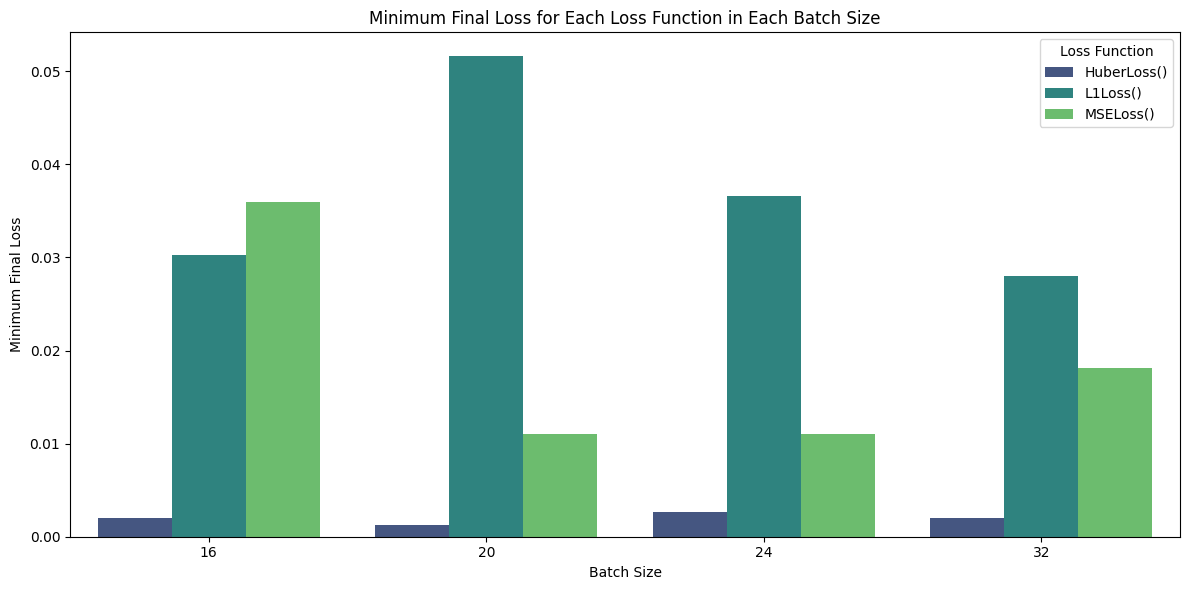

In [ ]:
# Assuming 'pivot_table' is your DataFrame with the necessary data
min_values = pivot_table.groupby(['batch size', 'Loss Function'])['Final Loss'].min().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=min_values, x='batch size', y='Final Loss', hue='Loss Function', palette='viridis')
plt.xlabel('Batch Size')
plt.ylabel('Minimum Final Loss')
plt.title('Minimum Final Loss for Each Loss Function in Each Batch Size')
plt.legend(title='Loss Function', loc='upper right')
plt.tight_layout()
plt.show()

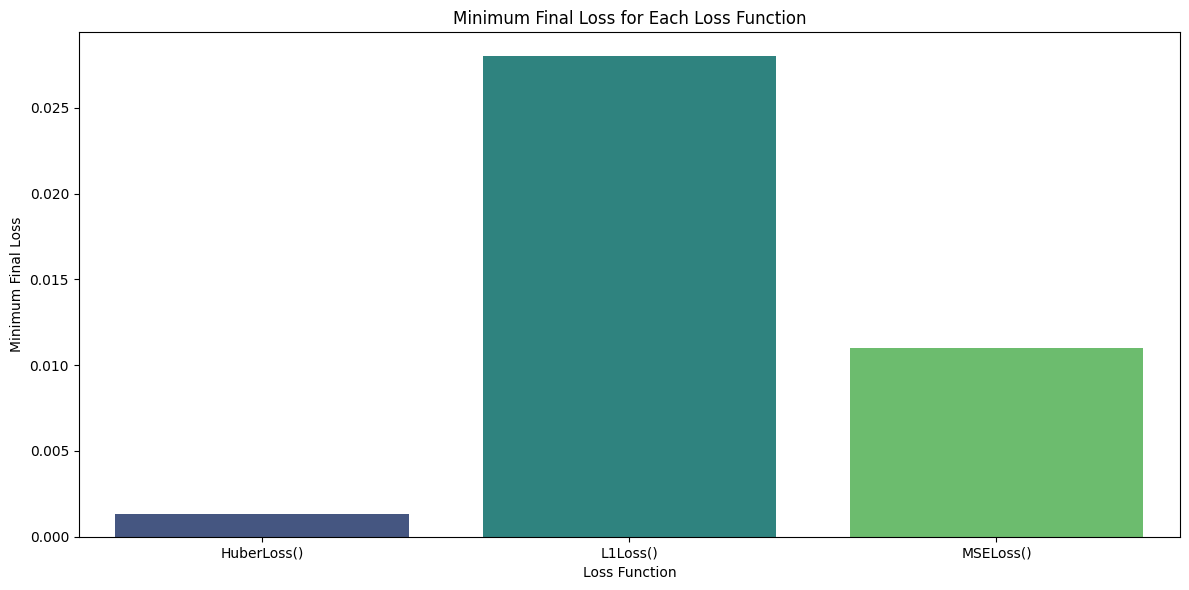

In [ ]:
# Assuming 'pivot_table' is your DataFrame with the necessary data
min_values = pivot_table.groupby('Loss Function')['Final Loss'].min().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=min_values, x='Loss Function', y='Final Loss', palette='viridis')
plt.xlabel('Loss Function')
plt.ylabel('Minimum Final Loss')
plt.title('Minimum Final Loss for Each Loss Function')
plt.tight_layout()
plt.show()

As a result of the  table and the graph, we chose batch 20.

As a result of the pivot table and graph, we chose the lr: 3.0e-04

---

### ***Create a training loop for batch 20***


100%|██████████| 1150/1150 [01:22<00:00, 14.01it/s]


Finished epoch 0. Average of the last 100 loss values: 0.039124


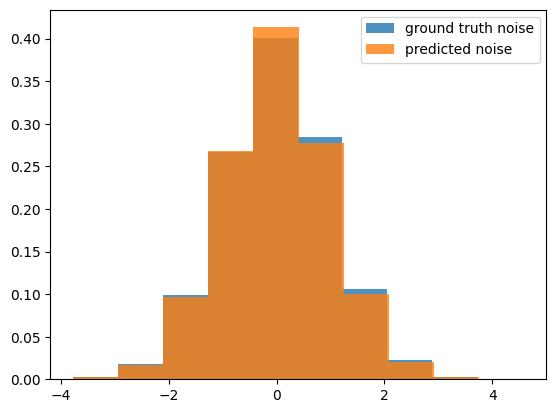

100%|██████████| 1150/1150 [01:19<00:00, 14.53it/s]


Finished epoch 1. Average of the last 100 loss values: 0.032298


100%|██████████| 1150/1150 [01:21<00:00, 14.12it/s]


Finished epoch 2. Average of the last 100 loss values: 0.024575


100%|██████████| 1150/1150 [01:23<00:00, 13.83it/s]


Finished epoch 3. Average of the last 100 loss values: 0.023113


100%|██████████| 1150/1150 [01:21<00:00, 14.14it/s]


Finished epoch 4. Average of the last 100 loss values: 0.021903


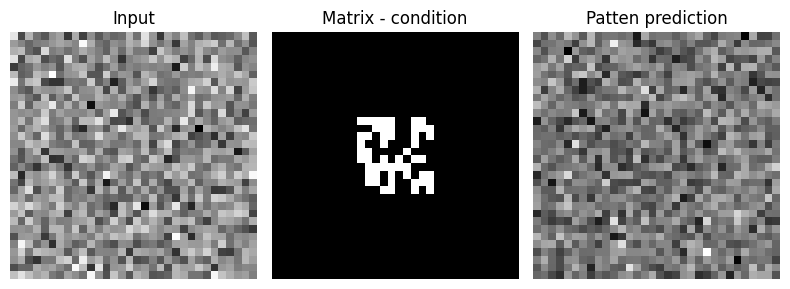

100%|██████████| 1150/1150 [01:24<00:00, 13.68it/s]


Finished epoch 5. Average of the last 100 loss values: 0.020752


100%|██████████| 1150/1150 [01:22<00:00, 13.91it/s]


Finished epoch 6. Average of the last 100 loss values: 0.021155


100%|██████████| 1150/1150 [01:19<00:00, 14.43it/s]


Finished epoch 7. Average of the last 100 loss values: 0.020215


100%|██████████| 1150/1150 [01:21<00:00, 14.07it/s]


Finished epoch 8. Average of the last 100 loss values: 0.019393


100%|██████████| 1150/1150 [01:20<00:00, 14.33it/s]


Finished epoch 9. Average of the last 100 loss values: 0.018131


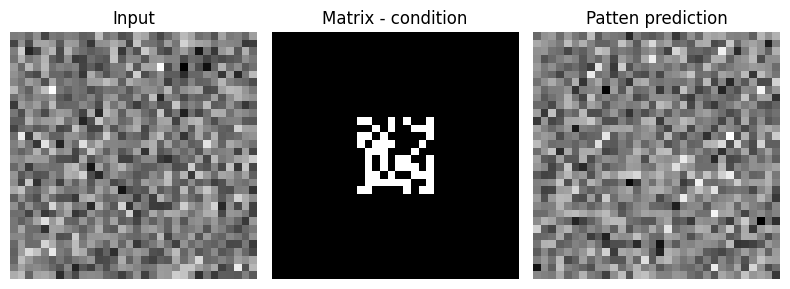

100%|██████████| 1150/1150 [01:19<00:00, 14.42it/s]


Finished epoch 10. Average of the last 100 loss values: 0.019993


100%|██████████| 1150/1150 [01:20<00:00, 14.21it/s]


Finished epoch 11. Average of the last 100 loss values: 0.018118


100%|██████████| 1150/1150 [01:22<00:00, 13.88it/s]


Finished epoch 12. Average of the last 100 loss values: 0.018325


100%|██████████| 1150/1150 [01:19<00:00, 14.47it/s]


Finished epoch 13. Average of the last 100 loss values: 0.017694


100%|██████████| 1150/1150 [01:21<00:00, 14.13it/s]


Finished epoch 14. Average of the last 100 loss values: 0.018090


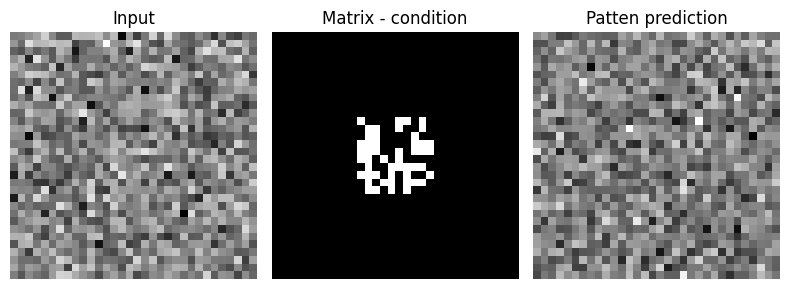

100%|██████████| 1150/1150 [01:21<00:00, 14.18it/s]


Finished epoch 15. Average of the last 100 loss values: 0.018365


100%|██████████| 1150/1150 [01:21<00:00, 14.17it/s]


Finished epoch 16. Average of the last 100 loss values: 0.017674


100%|██████████| 1150/1150 [01:22<00:00, 13.87it/s]


Finished epoch 17. Average of the last 100 loss values: 0.017191


100%|██████████| 1150/1150 [01:21<00:00, 14.19it/s]


Finished epoch 18. Average of the last 100 loss values: 0.017707


100%|██████████| 1150/1150 [01:21<00:00, 14.18it/s]


Finished epoch 19. Average of the last 100 loss values: 0.017639


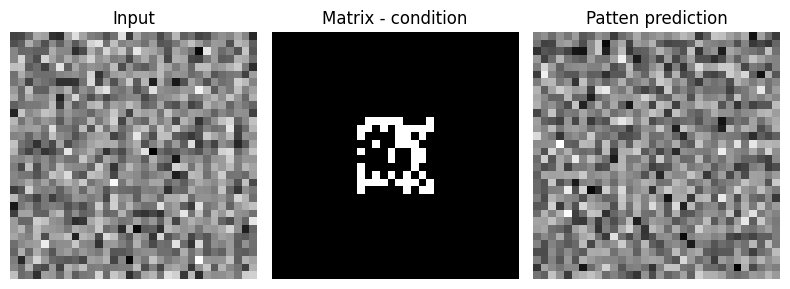

100%|██████████| 1150/1150 [01:19<00:00, 14.40it/s]


Finished epoch 20. Average of the last 100 loss values: 0.018582


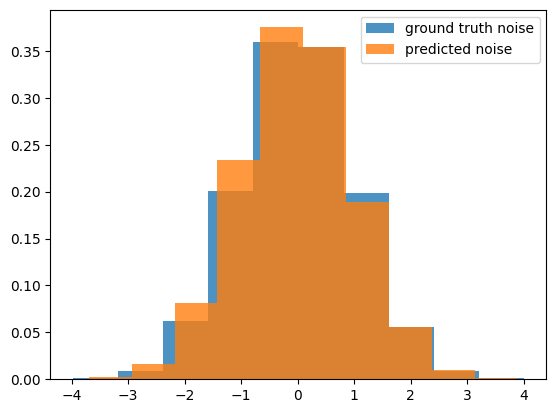

100%|██████████| 1150/1150 [01:21<00:00, 14.04it/s]


Finished epoch 21. Average of the last 100 loss values: 0.018878


100%|██████████| 1150/1150 [01:21<00:00, 14.03it/s]


Finished epoch 22. Average of the last 100 loss values: 0.017566


100%|██████████| 1150/1150 [01:19<00:00, 14.47it/s]


Finished epoch 23. Average of the last 100 loss values: 0.017723


100%|██████████| 1150/1150 [01:21<00:00, 14.15it/s]


Finished epoch 24. Average of the last 100 loss values: 0.017172


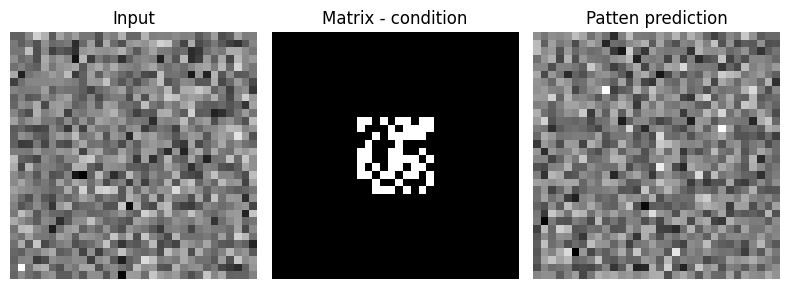

100%|██████████| 1150/1150 [01:21<00:00, 14.18it/s]


Finished epoch 25. Average of the last 100 loss values: 0.017405


100%|██████████| 1150/1150 [01:20<00:00, 14.37it/s]


Finished epoch 26. Average of the last 100 loss values: 0.016930


100%|██████████| 1150/1150 [01:20<00:00, 14.21it/s]


Finished epoch 27. Average of the last 100 loss values: 0.017553


100%|██████████| 1150/1150 [01:20<00:00, 14.21it/s]


Finished epoch 28. Average of the last 100 loss values: 0.017147


100%|██████████| 1150/1150 [01:20<00:00, 14.30it/s]


Finished epoch 29. Average of the last 100 loss values: 0.016761


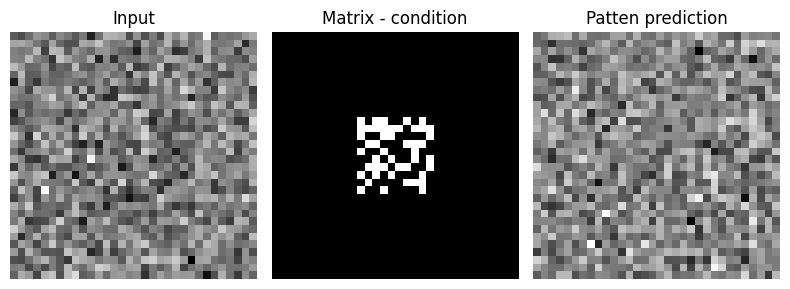

100%|██████████| 1150/1150 [01:19<00:00, 14.41it/s]


Finished epoch 30. Average of the last 100 loss values: 0.016559


100%|██████████| 1150/1150 [01:20<00:00, 14.36it/s]


Finished epoch 31. Average of the last 100 loss values: 0.017117


100%|██████████| 1150/1150 [01:21<00:00, 14.04it/s]


Finished epoch 32. Average of the last 100 loss values: 0.016772


100%|██████████| 1150/1150 [01:23<00:00, 13.85it/s]


Finished epoch 33. Average of the last 100 loss values: 0.016760


100%|██████████| 1150/1150 [01:23<00:00, 13.84it/s]


Finished epoch 34. Average of the last 100 loss values: 0.016645


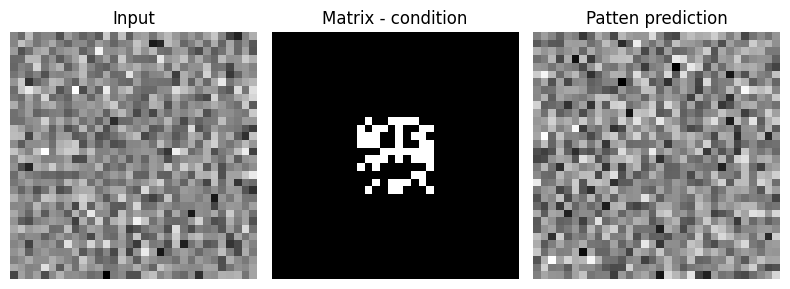

100%|██████████| 1150/1150 [01:22<00:00, 13.91it/s]


Finished epoch 35. Average of the last 100 loss values: 0.017118


100%|██████████| 1150/1150 [01:19<00:00, 14.41it/s]


Finished epoch 36. Average of the last 100 loss values: 0.016930


100%|██████████| 1150/1150 [01:21<00:00, 14.15it/s]


Finished epoch 37. Average of the last 100 loss values: 0.016655


100%|██████████| 1150/1150 [01:20<00:00, 14.35it/s]


Finished epoch 38. Average of the last 100 loss values: 0.017309


100%|██████████| 1150/1150 [01:19<00:00, 14.40it/s]


Finished epoch 39. Average of the last 100 loss values: 0.017762


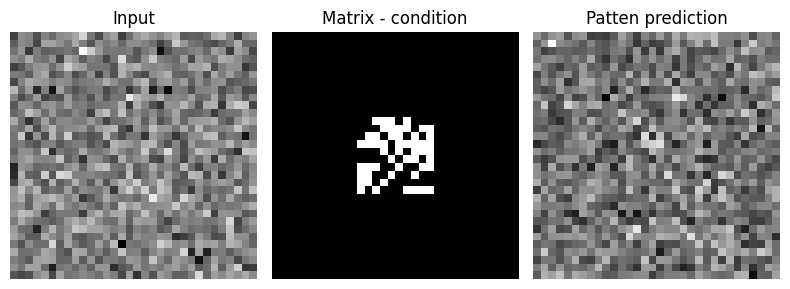

100%|██████████| 1150/1150 [01:21<00:00, 14.11it/s]


Finished epoch 40. Average of the last 100 loss values: 0.016499


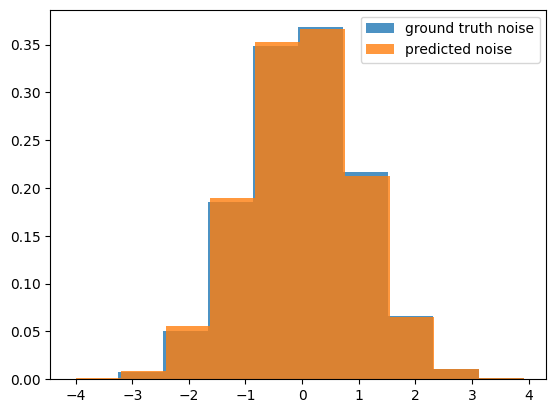

100%|██████████| 1150/1150 [01:20<00:00, 14.26it/s]


Finished epoch 41. Average of the last 100 loss values: 0.016955


100%|██████████| 1150/1150 [01:20<00:00, 14.35it/s]


Finished epoch 42. Average of the last 100 loss values: 0.017377


100%|██████████| 1150/1150 [01:20<00:00, 14.26it/s]


Finished epoch 43. Average of the last 100 loss values: 0.017532


100%|██████████| 1150/1150 [01:22<00:00, 13.92it/s]


Finished epoch 44. Average of the last 100 loss values: 0.016292


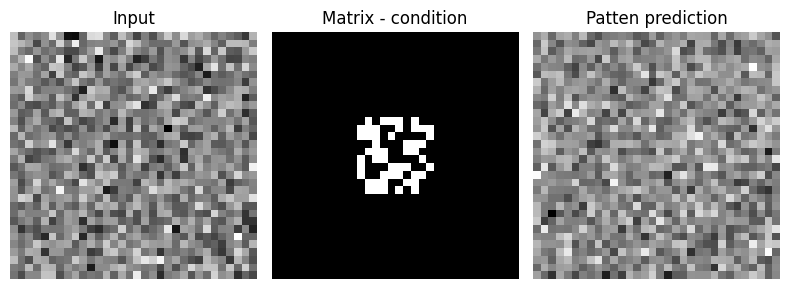

100%|██████████| 1150/1150 [01:19<00:00, 14.39it/s]


Finished epoch 45. Average of the last 100 loss values: 0.016553


100%|██████████| 1150/1150 [01:20<00:00, 14.26it/s]


Finished epoch 46. Average of the last 100 loss values: 0.017316


100%|██████████| 1150/1150 [01:21<00:00, 14.14it/s]


Finished epoch 47. Average of the last 100 loss values: 0.016566


100%|██████████| 1150/1150 [01:19<00:00, 14.40it/s]


Finished epoch 48. Average of the last 100 loss values: 0.017182


100%|██████████| 1150/1150 [01:20<00:00, 14.32it/s]


Finished epoch 49. Average of the last 100 loss values: 0.016971


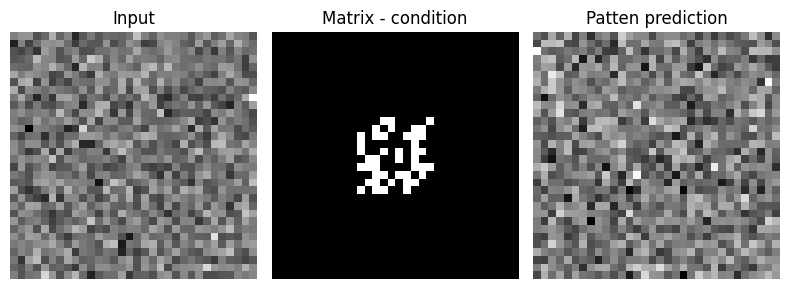

In [ ]:
timesteps=1000

# Our batch size
batch_size = 20

# Our network
model = ClassConditionedUnet().to(device)

# Number of epochs
n_epochs = 50

#Saving model
model_save_name ='trained_model_bs20.pt'
path = F"/content/drive/MyDrive/{model_save_name}"

#model.load_state_dict(torch.load(path))


# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for matrix , pattern in tqdm(train_loader):
        # Get some data and prepare the corrupted version
        matrix = matrix.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        pattern = pattern.to(device)
        noise = torch.randn_like(pattern)
        timesteps = torch.randint(0, 999, (pattern.shape[0],)).long().to(device)
        noisy_step = noise_scheduler.add_noise(pattern, noise, timesteps)
        # Get the model prediction
        pred = model(noisy_step, timesteps, matrix.long()) # Note that we pass in the labels y
        #pred = (pred > 0.5).float()

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

       #backward and updated params
        opt.zero_grad()
        loss.backward()
        opt.step()


        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')
    if ((epoch + 1) % 5 == 0):
      print_matrix(pred,noise,noisy_step)
      torch.save(model.state_dict(), path)

    if ((epoch) % 20 == 0 or epoch==0):
      plot_noise_distribution(noise, pred)

# Save the trained model after training is complete
torch.save(model.state_dict(), path)

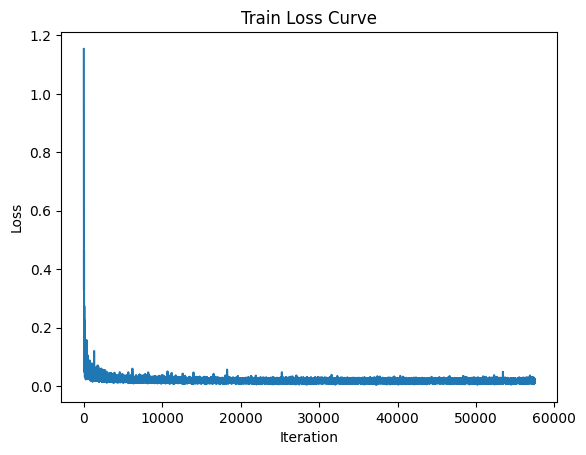

In [ ]:
# View the loss curve
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss Curve')
plt.grid(False)
plt.show()

  0%|          | 0/1150 [00:00<?, ?it/s]
0it [00:00, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


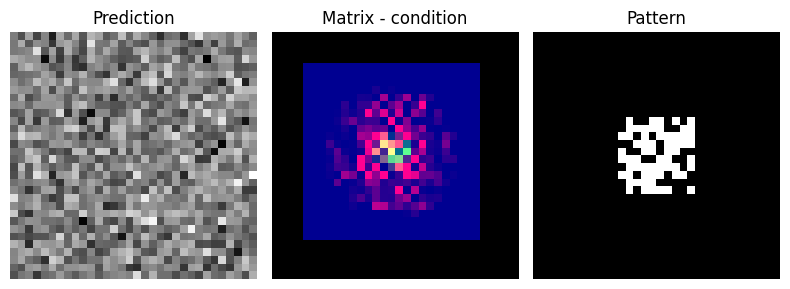


1it [00:00,  1.97it/s]
4it [00:00,  7.69it/s]
7it [00:00, 11.71it/s]
10it [00:00, 14.71it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


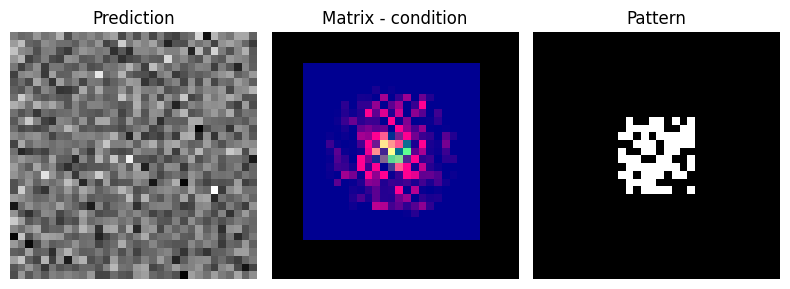


12it [00:01,  7.58it/s]
15it [00:01, 10.09it/s]
17it [00:01, 11.41it/s]
20it [00:01, 13.87it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


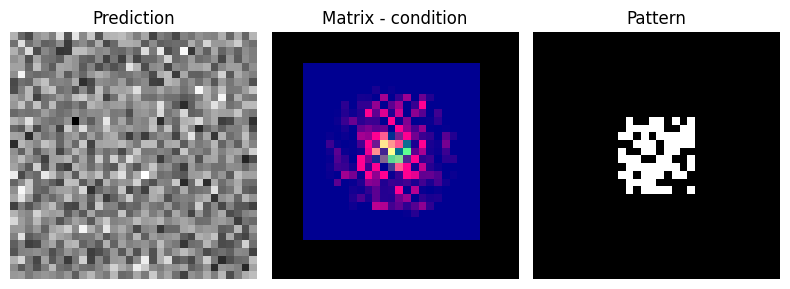


22it [00:02,  9.31it/s]
27it [00:02, 14.70it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


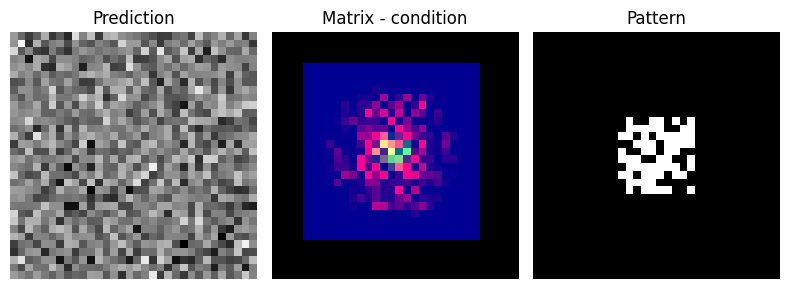


31it [00:02, 13.26it/s]
35it [00:02, 17.06it/s]
40it [00:02, 21.85it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


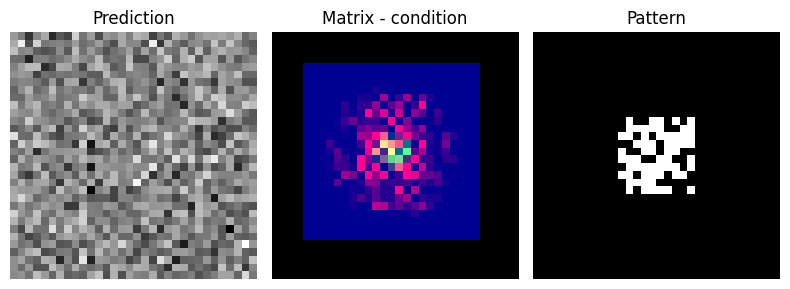


43it [00:03, 15.93it/s]
48it [00:03, 20.78it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


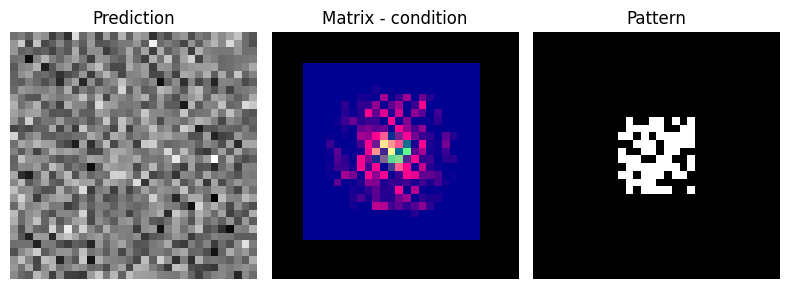


51it [00:03, 15.93it/s]
55it [00:03, 19.60it/s]
60it [00:04, 24.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


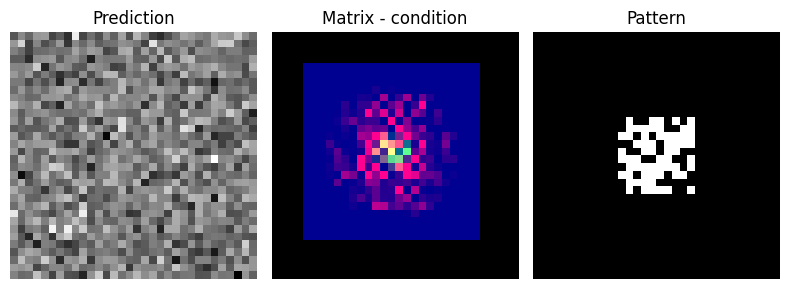


64it [00:04, 17.89it/s]
69it [00:04, 22.40it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


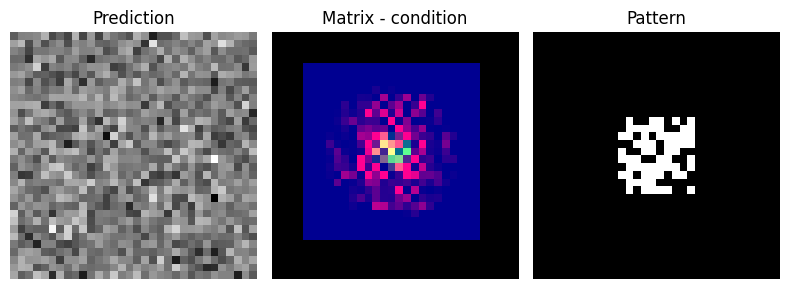


73it [00:04, 17.64it/s]
78it [00:04, 21.99it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


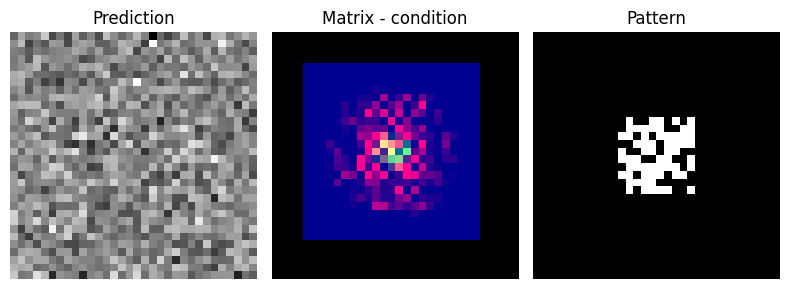


82it [00:05, 17.11it/s]
87it [00:05, 21.39it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


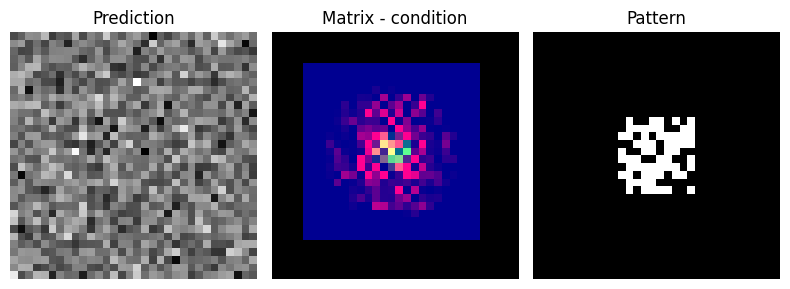


91it [00:06, 10.88it/s]
94it [00:06, 11.69it/s]
98it [00:06, 14.40it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


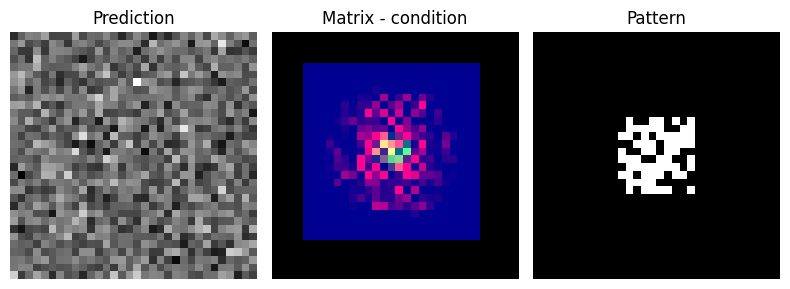


101it [00:07, 11.13it/s]
104it [00:07, 13.05it/s]
108it [00:07, 16.31it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


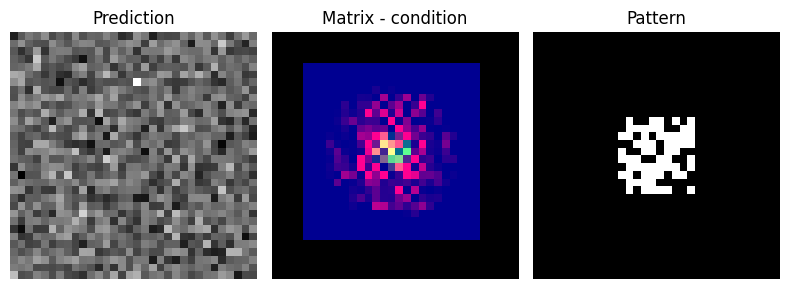


111it [00:07, 11.61it/s]
114it [00:07, 13.89it/s]
117it [00:07, 16.33it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


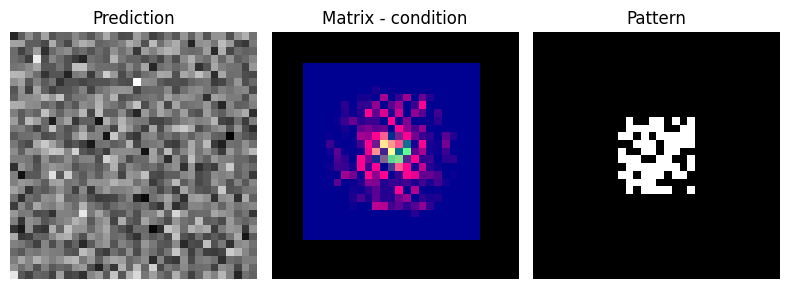


121it [00:08, 11.55it/s]
124it [00:08, 13.75it/s]
127it [00:08, 15.82it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


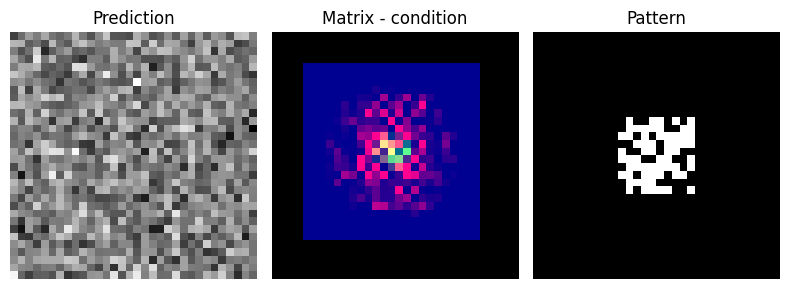


131it [00:09, 11.97it/s]
134it [00:09, 14.24it/s]
138it [00:09, 17.33it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


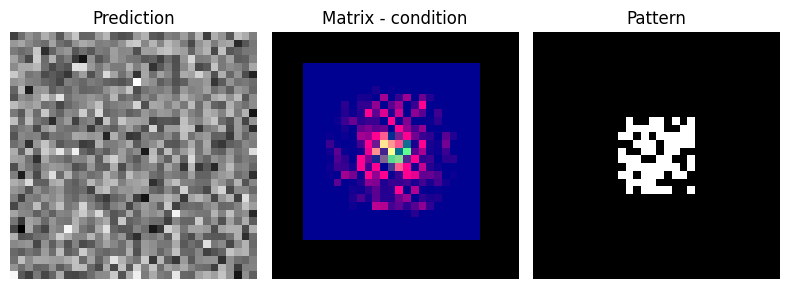


141it [00:09, 11.74it/s]
145it [00:10, 14.91it/s]
149it [00:10, 17.75it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


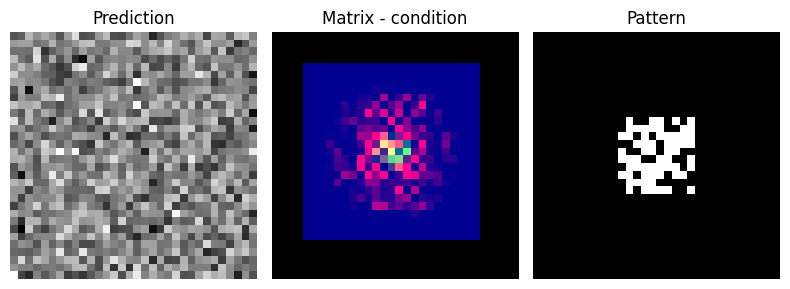


152it [00:10, 11.45it/s]
155it [00:10, 13.51it/s]
158it [00:10, 15.86it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


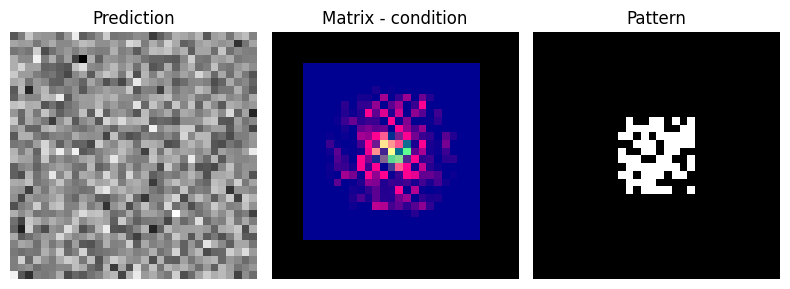


161it [00:12,  6.88it/s]
165it [00:12,  9.65it/s]
169it [00:12, 12.81it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


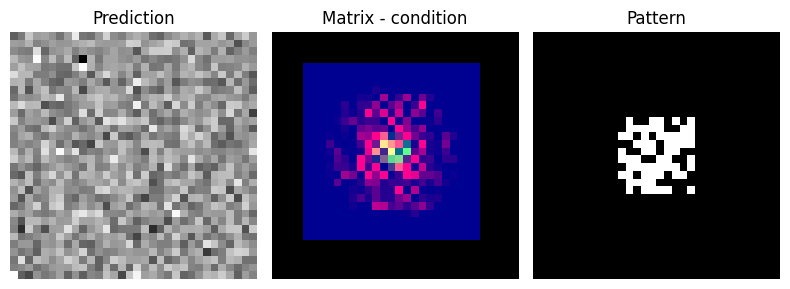


172it [00:12, 11.22it/s]
176it [00:12, 14.76it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


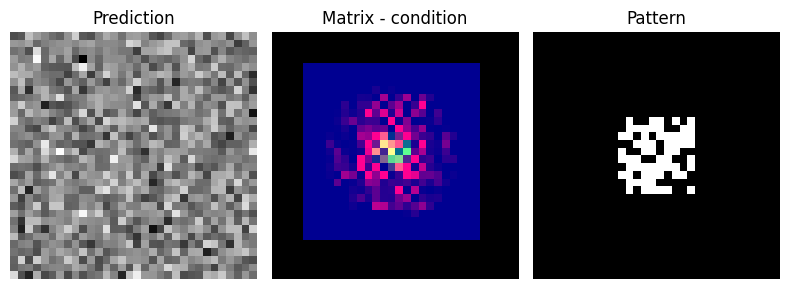


181it [00:13, 13.95it/s]
185it [00:13, 17.16it/s]
190it [00:13, 21.63it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


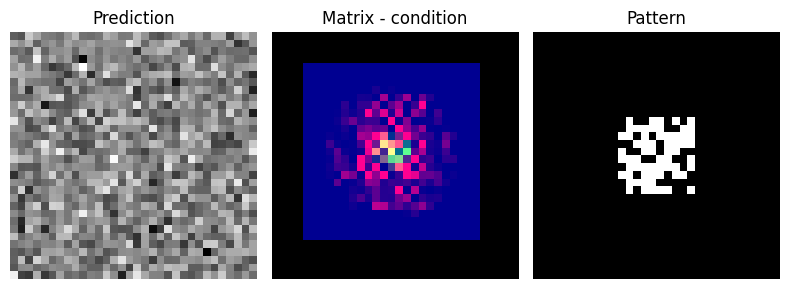


194it [00:13, 16.99it/s]
199it [00:13, 21.33it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


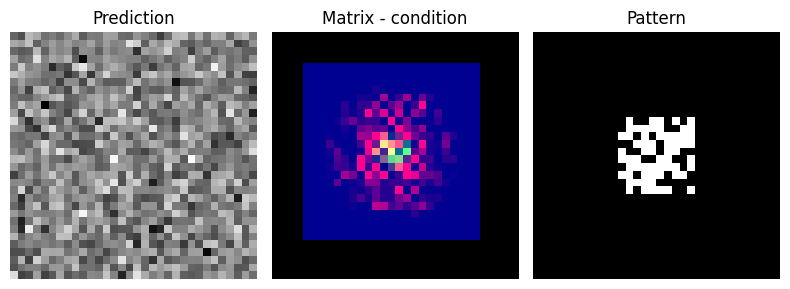


203it [00:14, 16.69it/s]
207it [00:14, 19.91it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


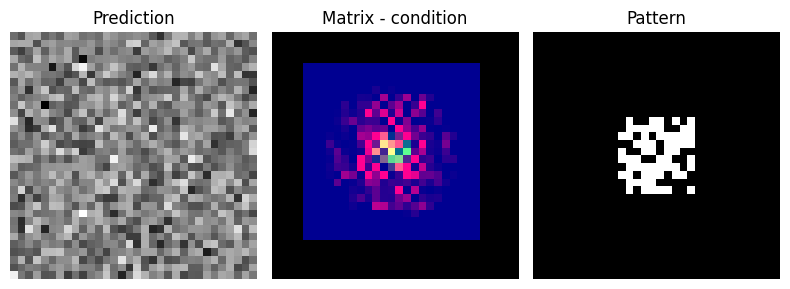


211it [00:14, 16.21it/s]
215it [00:14, 19.52it/s]
220it [00:14, 23.77it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


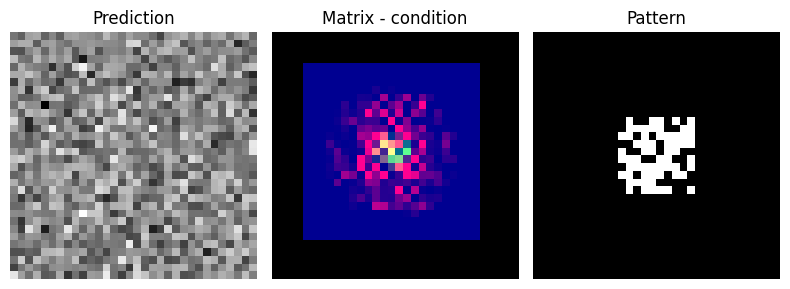


224it [00:15, 17.70it/s]
228it [00:15, 21.00it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


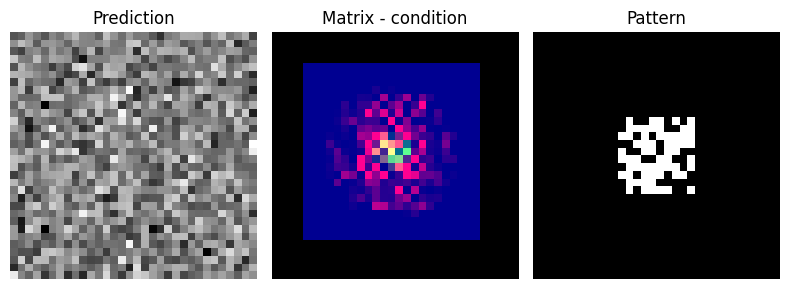


231it [00:15, 15.62it/s]
235it [00:15, 18.94it/s]
239it [00:15, 22.34it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


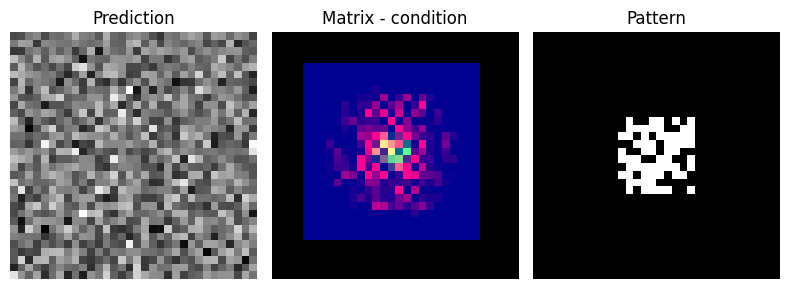


243it [00:16, 16.76it/s]
247it [00:16, 20.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


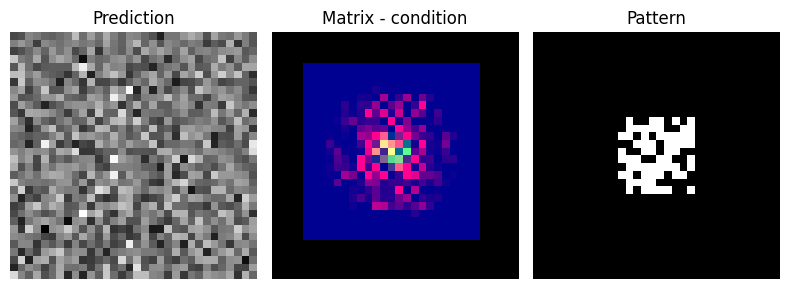


251it [00:16, 15.76it/s]
255it [00:16, 19.16it/s]
260it [00:16, 23.62it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


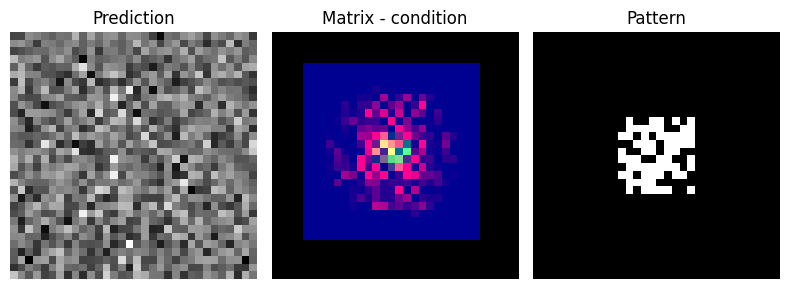


264it [00:17, 17.66it/s]
268it [00:17, 20.87it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


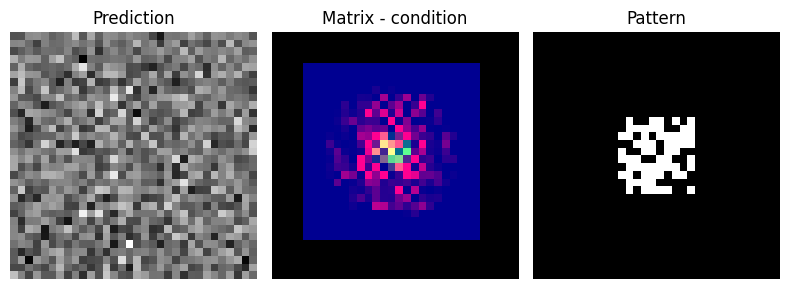


271it [00:17, 15.78it/s]
275it [00:17, 19.25it/s]
279it [00:17, 22.68it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


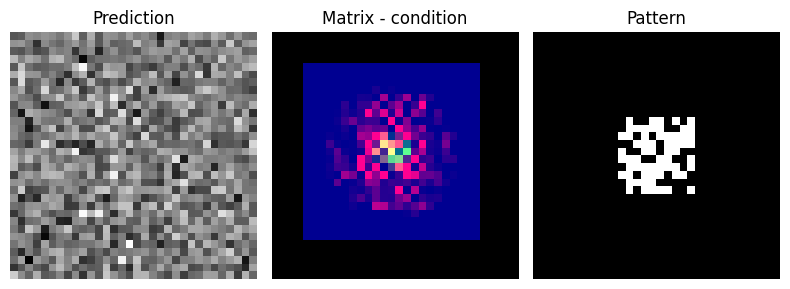


283it [00:18, 17.23it/s]
287it [00:18, 20.80it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


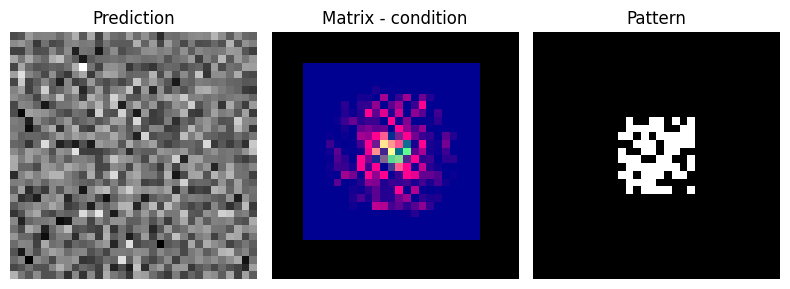


291it [00:18, 16.26it/s]
295it [00:18, 19.68it/s]
299it [00:19, 23.18it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


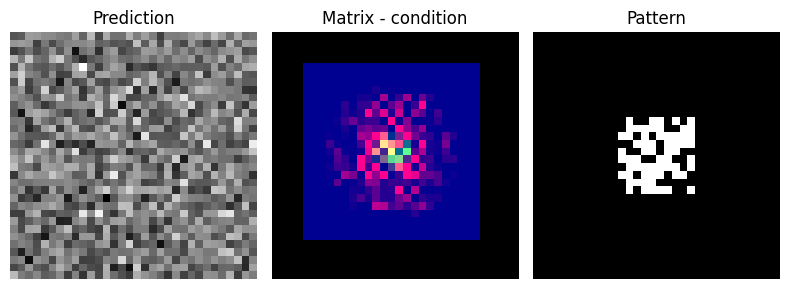


303it [00:19, 17.08it/s]
307it [00:19, 20.63it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


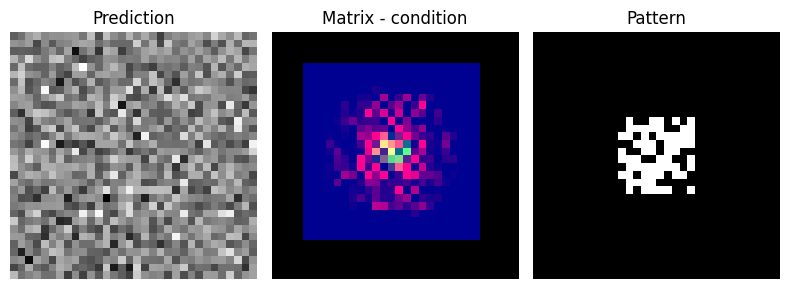


311it [00:19, 16.02it/s]
314it [00:19, 17.96it/s]
317it [00:20, 18.88it/s]
320it [00:20, 18.38it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


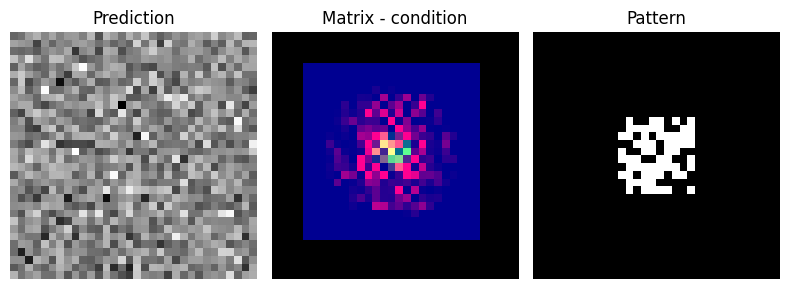


323it [00:21,  9.13it/s]
325it [00:21, 10.30it/s]
327it [00:21, 10.72it/s]
329it [00:21, 10.35it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


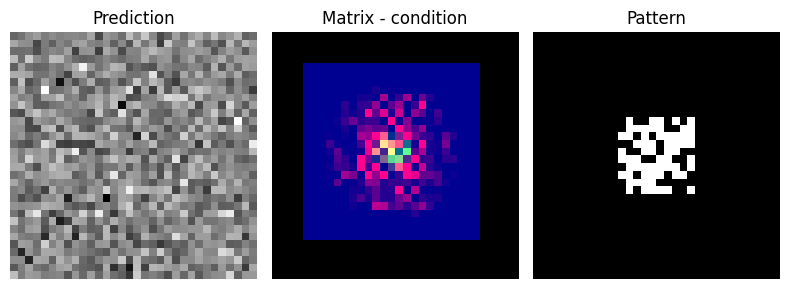


331it [00:22,  4.79it/s]
333it [00:22,  5.78it/s]
335it [00:22,  6.58it/s]
337it [00:23,  6.87it/s]
338it [00:23,  7.03it/s]
339it [00:23,  7.17it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


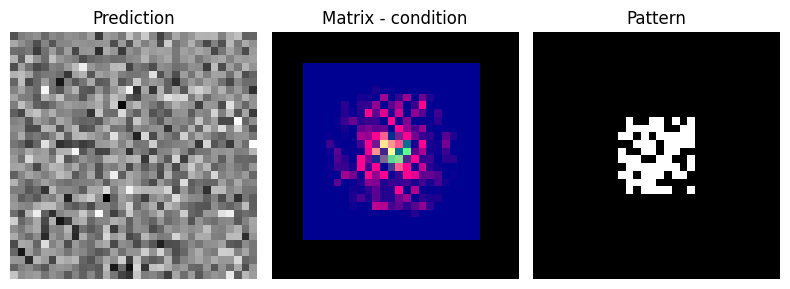


341it [00:23,  5.61it/s]
344it [00:24,  8.41it/s]
347it [00:24, 11.42it/s]
350it [00:24, 14.53it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


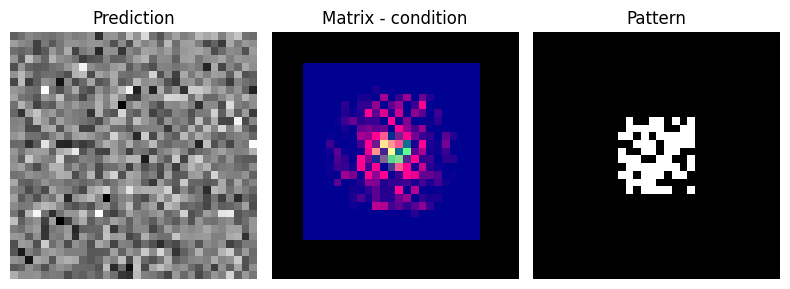


353it [00:24,  9.80it/s]
356it [00:24, 12.20it/s]
359it [00:25, 14.48it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


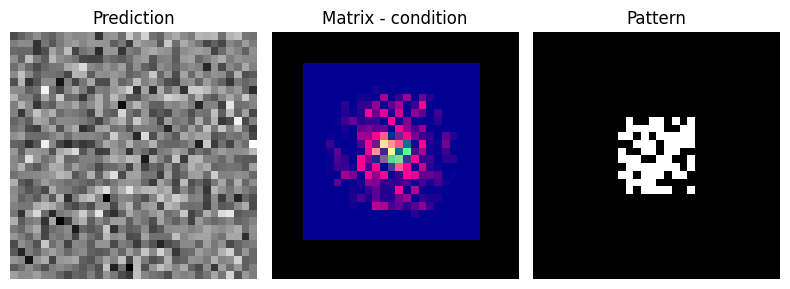


362it [00:25,  9.76it/s]
366it [00:25, 13.13it/s]
369it [00:25, 15.58it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


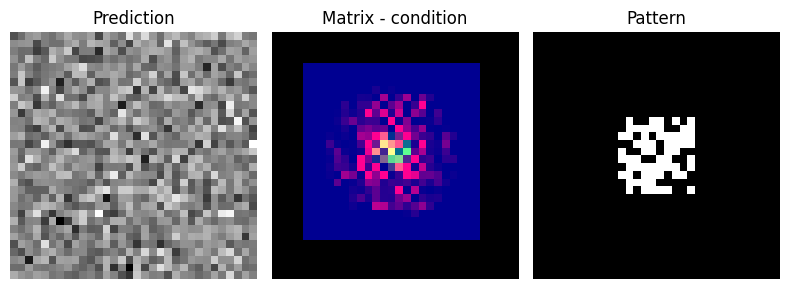


372it [00:26, 10.79it/s]
376it [00:26, 14.18it/s]
379it [00:26, 16.44it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


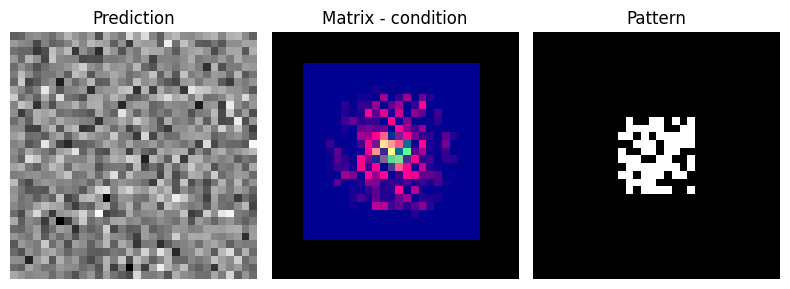


382it [00:27, 10.93it/s]
385it [00:27, 13.15it/s]
388it [00:27, 15.42it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


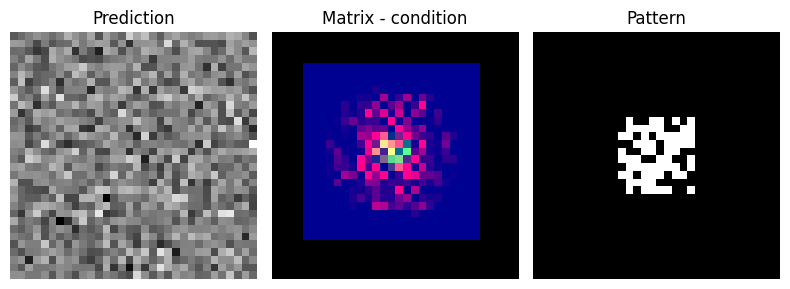


391it [00:27, 11.94it/s]
395it [00:27, 15.79it/s]
399it [00:27, 19.70it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


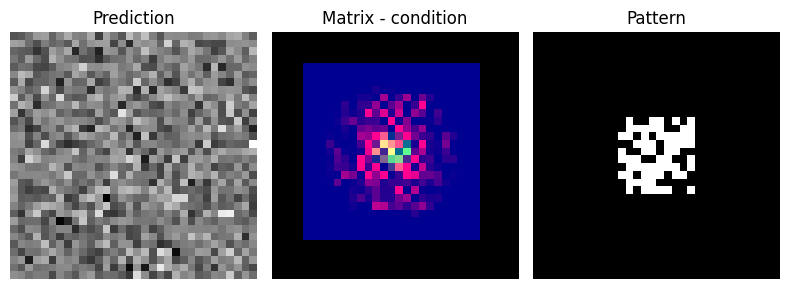


402it [00:28, 14.24it/s]
406it [00:28, 18.05it/s]
410it [00:28, 21.73it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


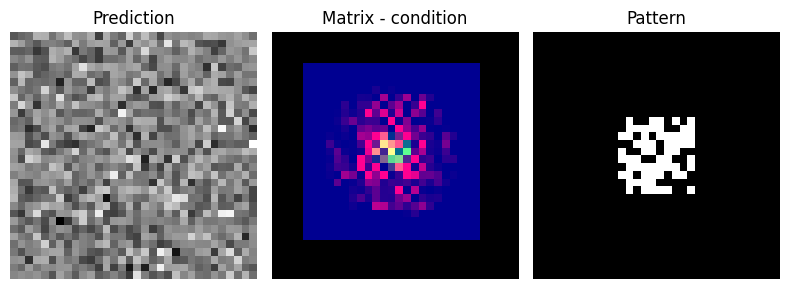


414it [00:28, 15.95it/s]
418it [00:28, 19.62it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


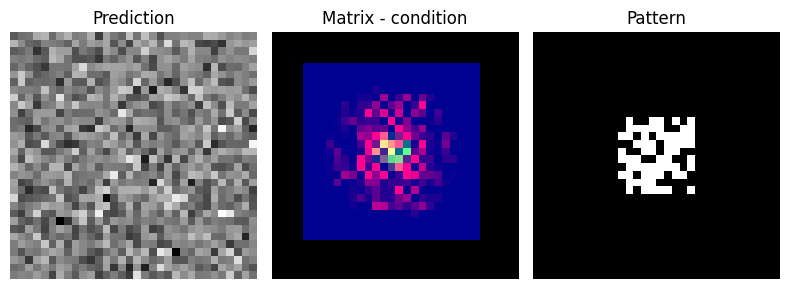


421it [00:29, 14.76it/s]
425it [00:29, 18.37it/s]
429it [00:29, 22.13it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


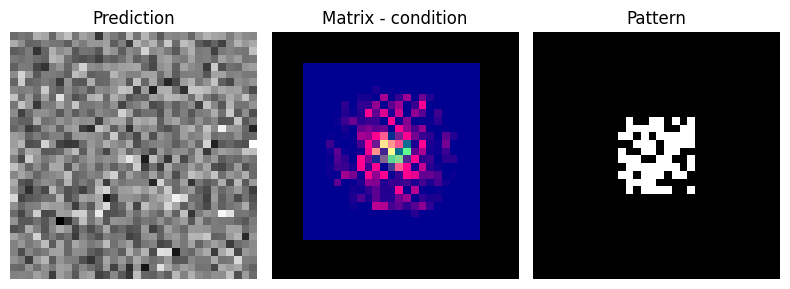


433it [00:30,  9.29it/s]
437it [00:30, 12.03it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


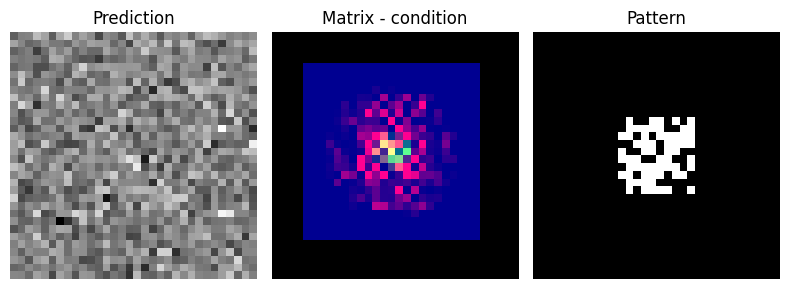


441it [00:30, 11.71it/s]
445it [00:31, 14.57it/s]
449it [00:31, 17.85it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


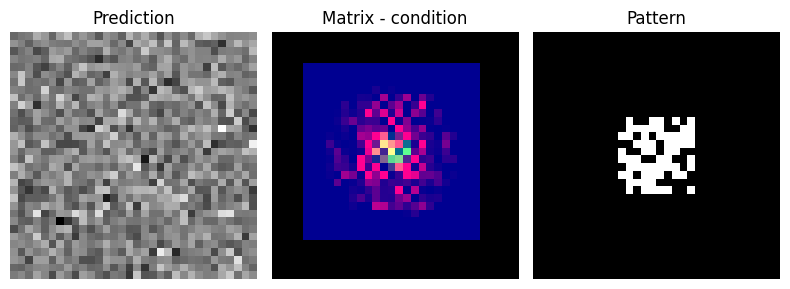


452it [00:31, 14.04it/s]
456it [00:31, 17.63it/s]
460it [00:31, 21.16it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


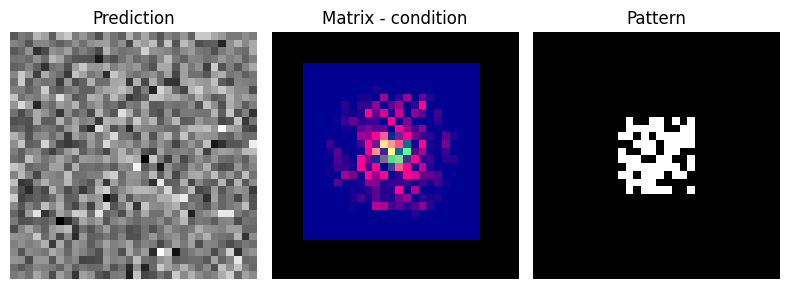


464it [00:32, 16.00it/s]
468it [00:32, 19.24it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


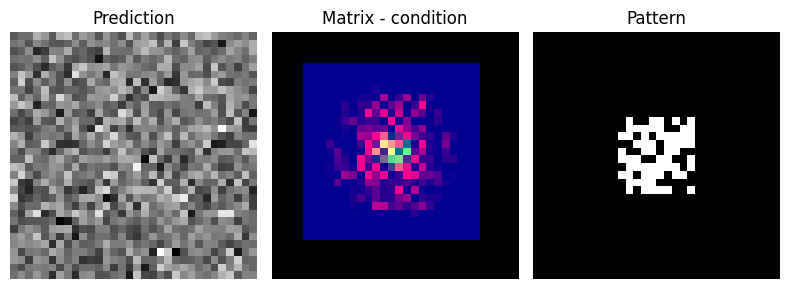


471it [00:32, 14.41it/s]
475it [00:32, 17.89it/s]
479it [00:32, 21.45it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


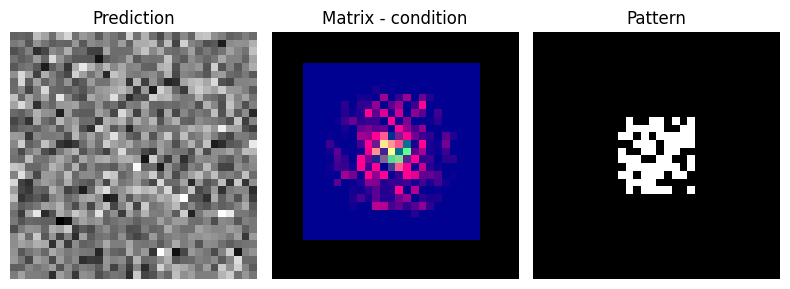


482it [00:33, 15.36it/s]
486it [00:33, 18.76it/s]
489it [00:33, 20.44it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


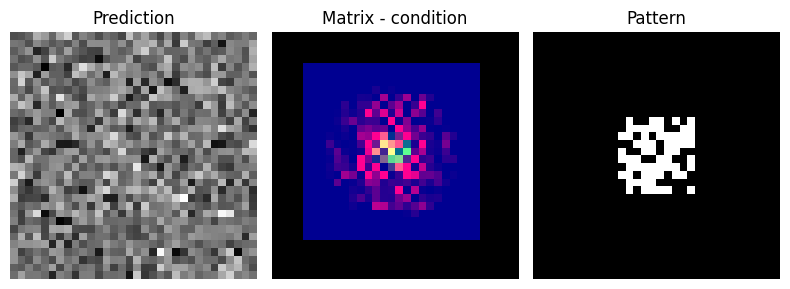


492it [00:33, 14.80it/s]
496it [00:33, 18.61it/s]
500it [00:33, 22.11it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


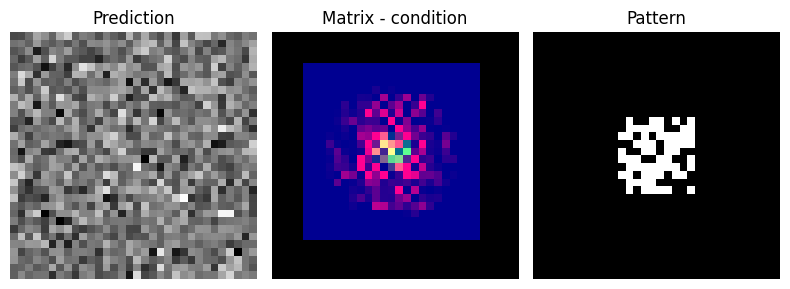


503it [00:34, 15.65it/s]
507it [00:34, 19.08it/s]
510it [00:34, 14.66it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


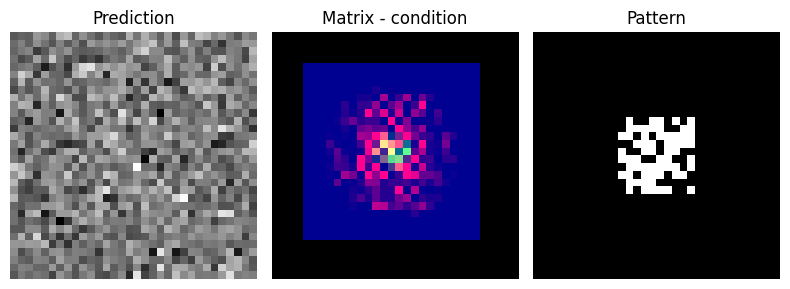


513it [00:35,  9.17it/s]
517it [00:35, 12.32it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


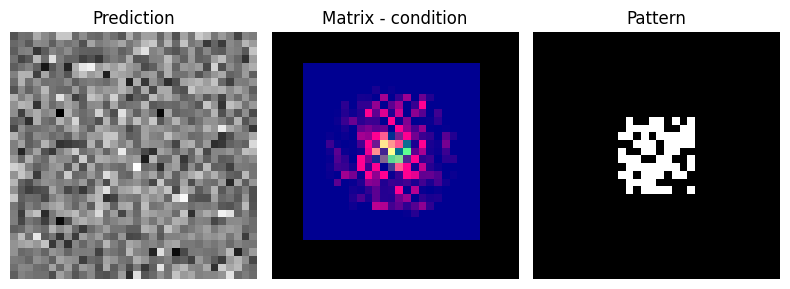


521it [00:35, 11.88it/s]
525it [00:36, 14.94it/s]
529it [00:36, 18.43it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


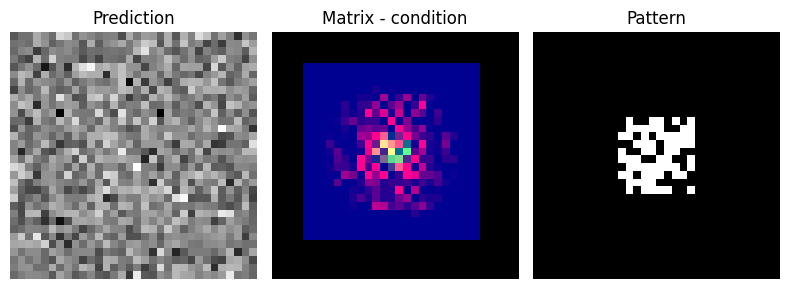


532it [00:36, 14.19it/s]
536it [00:36, 17.57it/s]
540it [00:36, 21.19it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


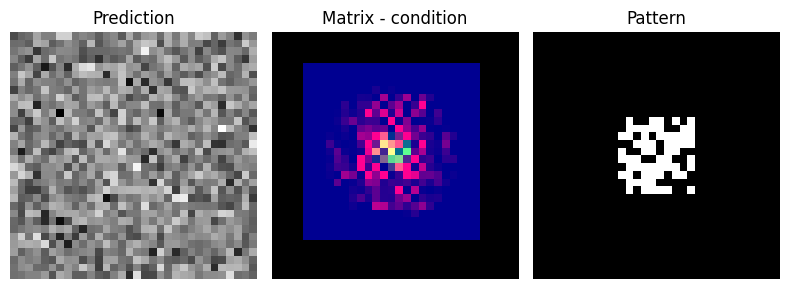


543it [00:37, 15.32it/s]
547it [00:37, 18.87it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


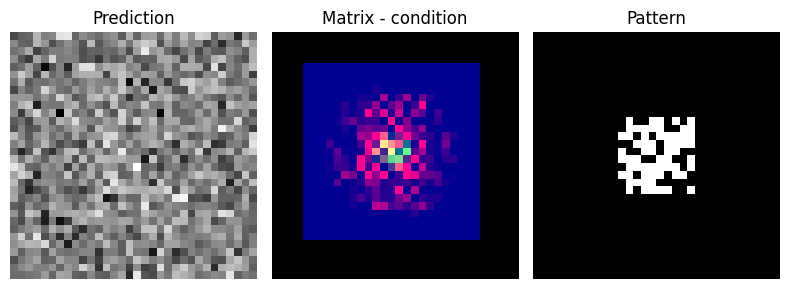


551it [00:37, 14.03it/s]
554it [00:37, 15.44it/s]
557it [00:37, 17.29it/s]
560it [00:37, 18.90it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


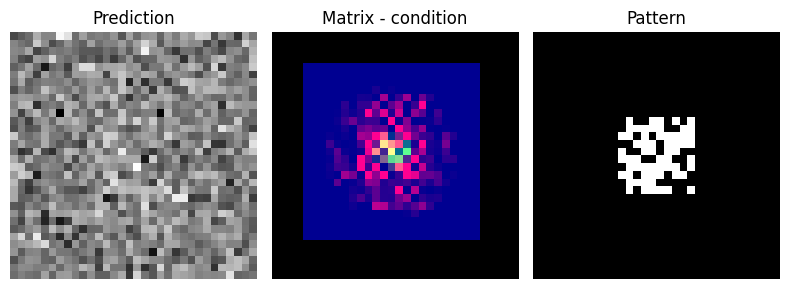


563it [00:38,  8.56it/s]
565it [00:39,  8.63it/s]
567it [00:39,  9.71it/s]
569it [00:39, 10.12it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


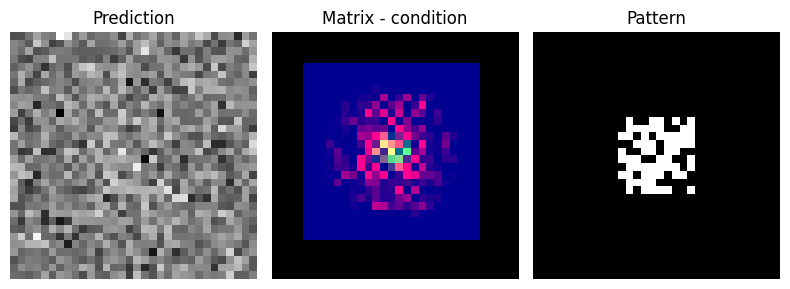


571it [00:40,  4.46it/s]
573it [00:40,  4.68it/s]
574it [00:41,  4.88it/s]
575it [00:41,  4.99it/s]
576it [00:41,  5.05it/s]
577it [00:41,  5.40it/s]
578it [00:41,  5.35it/s]
579it [00:41,  5.46it/s]
580it [00:42,  5.75it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


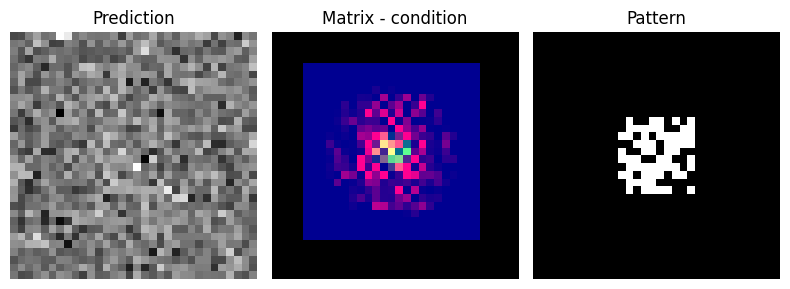


581it [00:43,  1.76it/s]
582it [00:43,  2.25it/s]
583it [00:43,  2.79it/s]
584it [00:44,  3.32it/s]
585it [00:44,  3.89it/s]
586it [00:44,  4.56it/s]
587it [00:44,  5.00it/s]
588it [00:44,  5.61it/s]
590it [00:44,  7.89it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


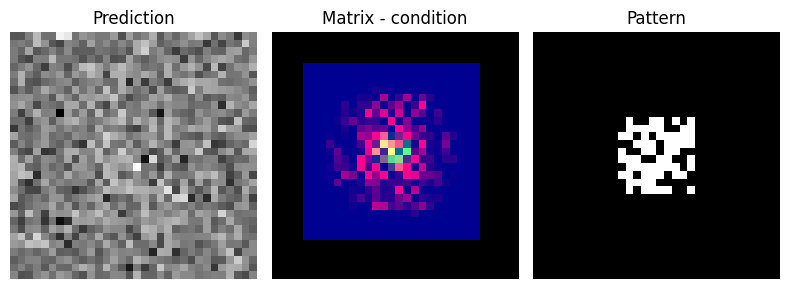


591it [00:45,  3.52it/s]
593it [00:45,  5.04it/s]
595it [00:45,  6.57it/s]
597it [00:46,  7.53it/s]
599it [00:46,  7.66it/s]
600it [00:46,  7.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


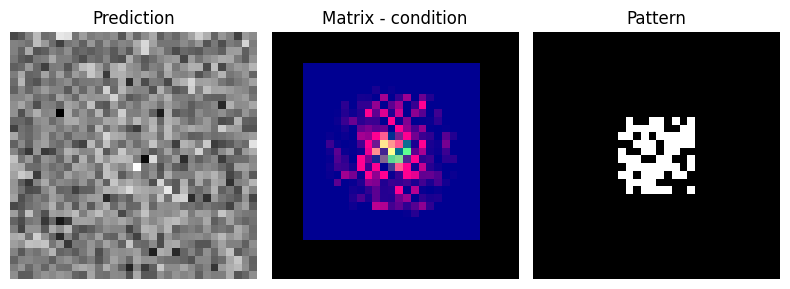


601it [00:47,  3.21it/s]
603it [00:47,  4.37it/s]
604it [00:47,  4.91it/s]
606it [00:47,  6.54it/s]
607it [00:47,  6.62it/s]
608it [00:48,  6.54it/s]
609it [00:48,  7.09it/s]
610it [00:48,  7.32it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


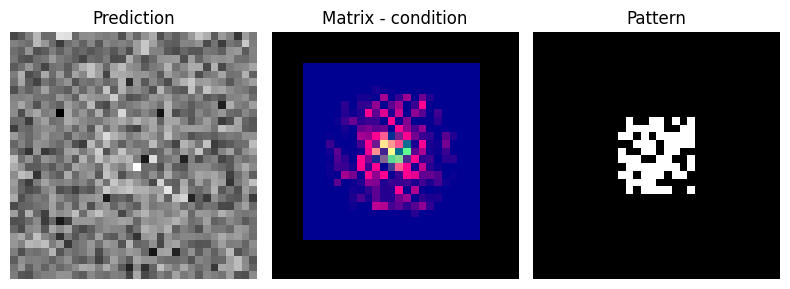


611it [00:49,  3.28it/s]
612it [00:49,  3.93it/s]
614it [00:49,  5.87it/s]
616it [00:49,  7.85it/s]
618it [00:49,  9.83it/s]
620it [00:49, 11.54it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


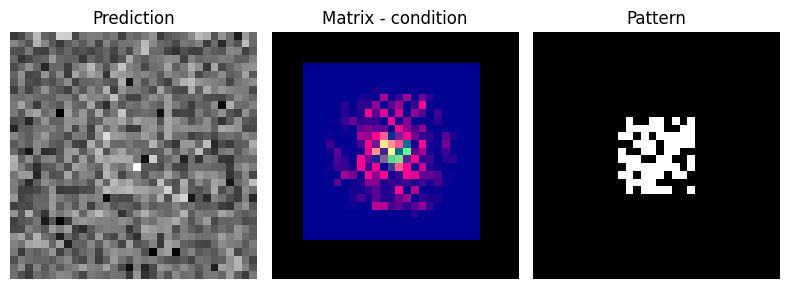


622it [00:50,  6.24it/s]
624it [00:50,  7.62it/s]
626it [00:50,  8.88it/s]
628it [00:50, 10.58it/s]
630it [00:50, 11.92it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


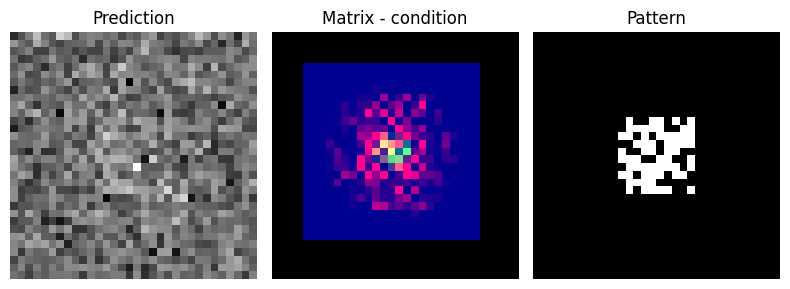


632it [00:51,  6.53it/s]
634it [00:51,  8.08it/s]
636it [00:51,  9.45it/s]
638it [00:51, 10.68it/s]
640it [00:51, 11.79it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


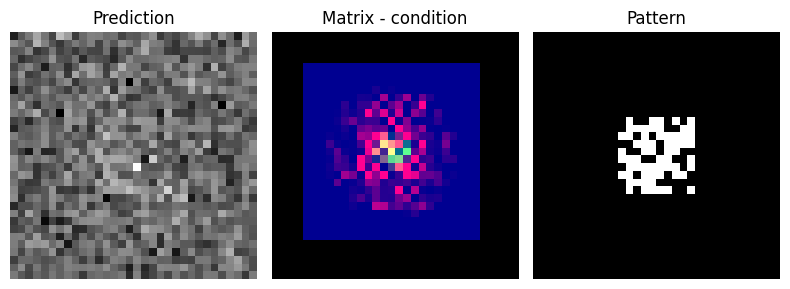


642it [00:52,  5.23it/s]
644it [00:53,  6.15it/s]
646it [00:53,  6.78it/s]
648it [00:53,  7.93it/s]
650it [00:53,  8.57it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


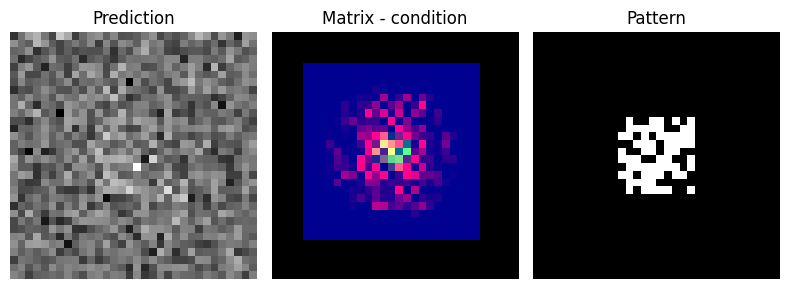


652it [00:56,  2.23it/s]
653it [00:56,  2.50it/s]
654it [00:56,  2.94it/s]
655it [00:56,  3.45it/s]
656it [00:56,  4.01it/s]
657it [00:56,  4.22it/s]
658it [00:56,  4.68it/s]
659it [00:57,  5.33it/s]
660it [00:57,  5.79it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


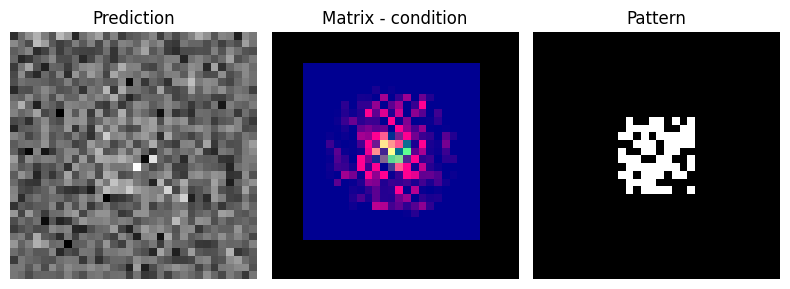


661it [00:58,  2.03it/s]
662it [00:58,  2.63it/s]
663it [00:58,  3.32it/s]
665it [00:58,  4.84it/s]
666it [00:58,  5.54it/s]
667it [00:59,  5.99it/s]
668it [00:59,  6.24it/s]
669it [00:59,  6.91it/s]
670it [00:59,  7.49it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


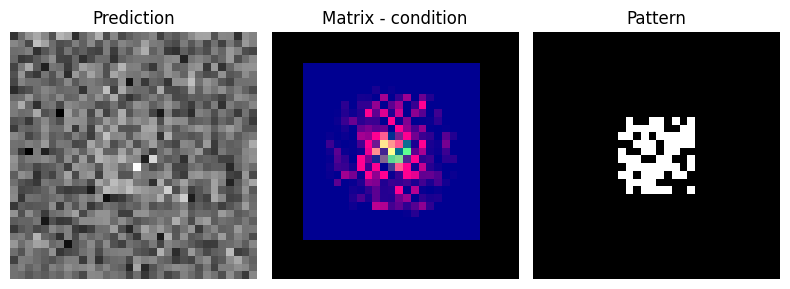


671it [01:00,  2.14it/s]
672it [01:00,  2.65it/s]
673it [01:01,  3.32it/s]
675it [01:01,  4.79it/s]
676it [01:01,  5.29it/s]
677it [01:01,  5.69it/s]
678it [01:01,  6.42it/s]
679it [01:01,  6.70it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


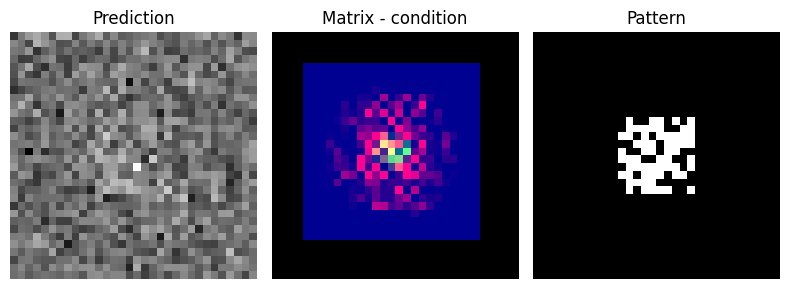


681it [01:02,  3.86it/s]
683it [01:02,  5.55it/s]
685it [01:02,  7.25it/s]
687it [01:02,  8.97it/s]
689it [01:03, 10.33it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


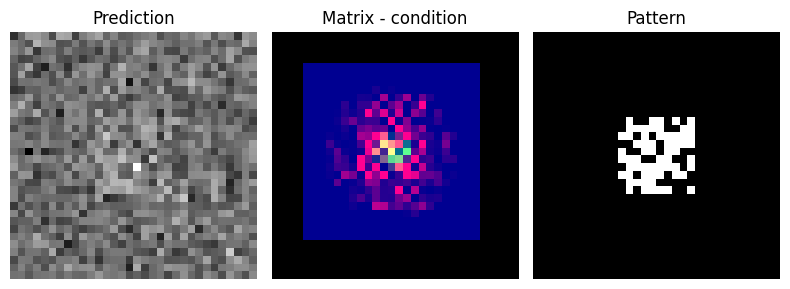


691it [01:04,  3.07it/s]
693it [01:04,  4.04it/s]
695it [01:04,  5.26it/s]
697it [01:05,  6.66it/s]
700it [01:05,  9.14it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


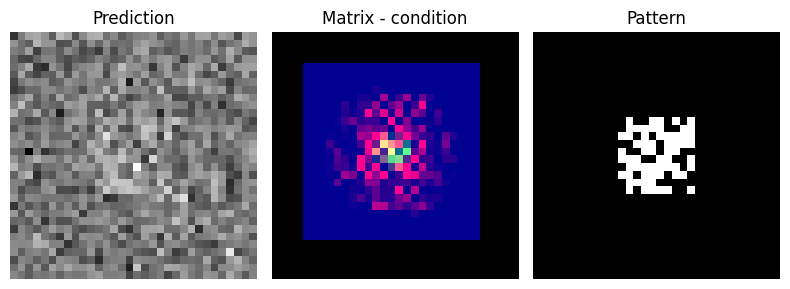


702it [01:05,  6.29it/s]
704it [01:05,  7.25it/s]
706it [01:06,  8.54it/s]
709it [01:06, 11.13it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


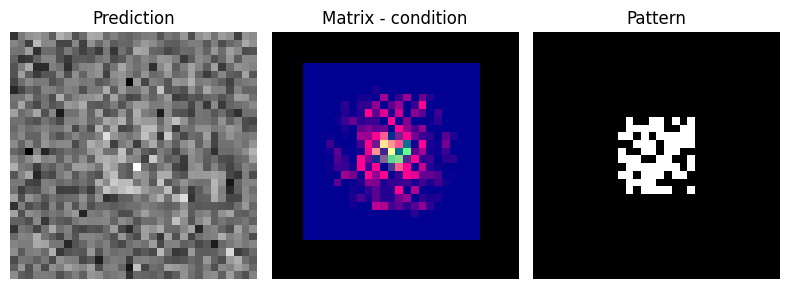


711it [01:06,  6.52it/s]
713it [01:06,  7.84it/s]
715it [01:07,  9.20it/s]
717it [01:07, 10.05it/s]
719it [01:07, 11.11it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


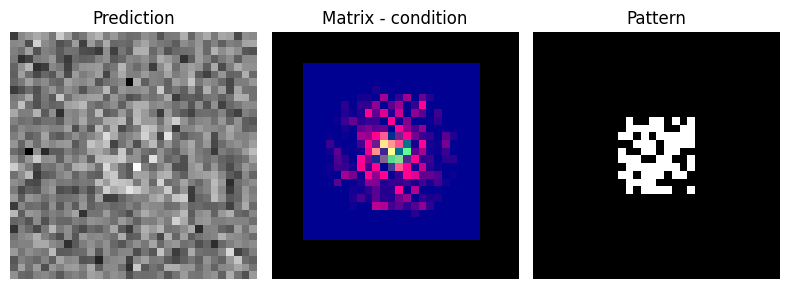


721it [01:07,  6.66it/s]
723it [01:08,  7.70it/s]
726it [01:08, 10.23it/s]
729it [01:08, 12.70it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


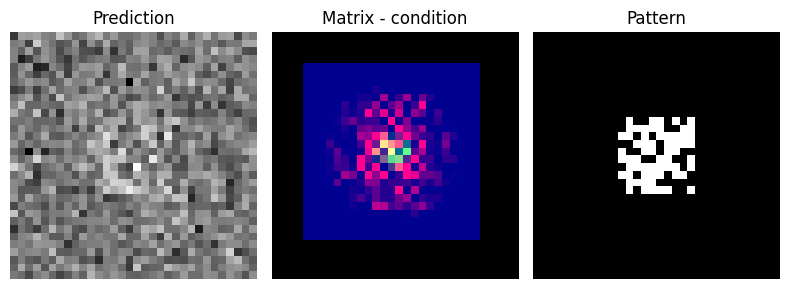


731it [01:08,  9.86it/s]
735it [01:08, 14.01it/s]
739it [01:08, 17.90it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


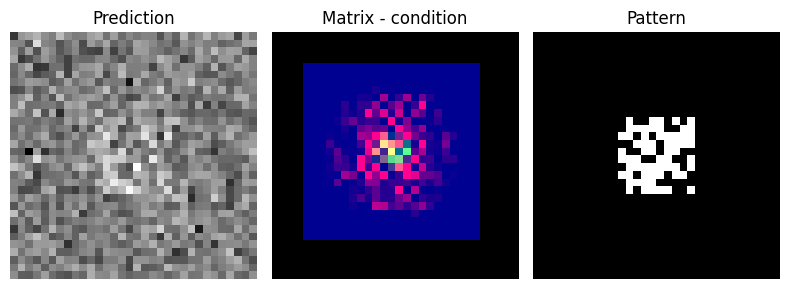


742it [01:09, 13.38it/s]
746it [01:09, 17.04it/s]
750it [01:09, 20.65it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


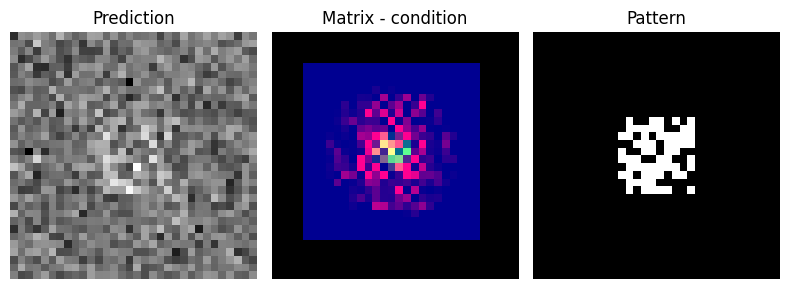


753it [01:09, 14.27it/s]
757it [01:10, 17.77it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


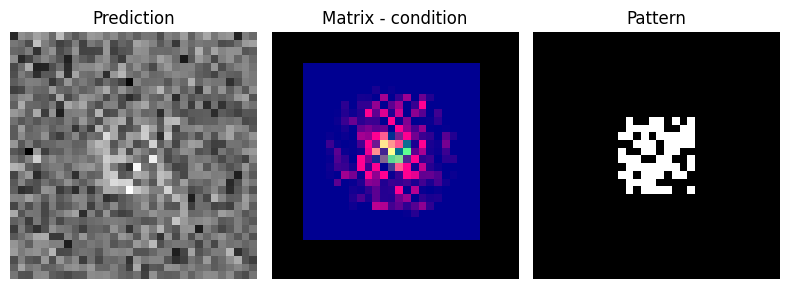


761it [01:10, 14.57it/s]
764it [01:10, 16.58it/s]
767it [01:10, 18.10it/s]
770it [01:10, 19.61it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


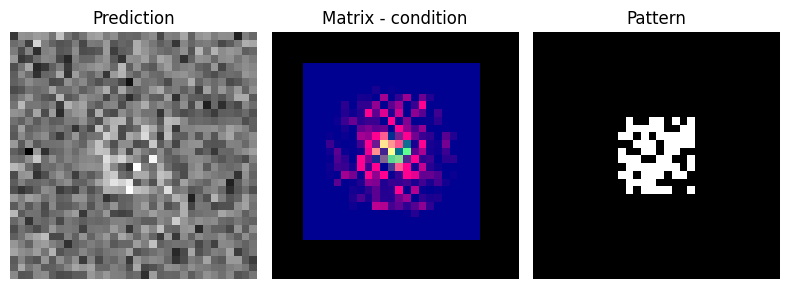


773it [01:11, 11.58it/s]
776it [01:11, 13.91it/s]
779it [01:11, 16.04it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


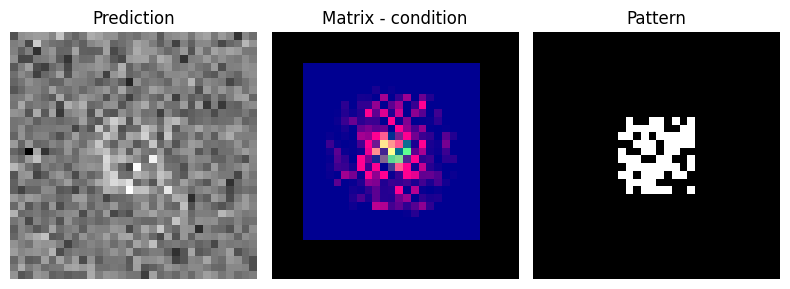


782it [01:12, 10.80it/s]
785it [01:12, 13.29it/s]
788it [01:12, 15.78it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


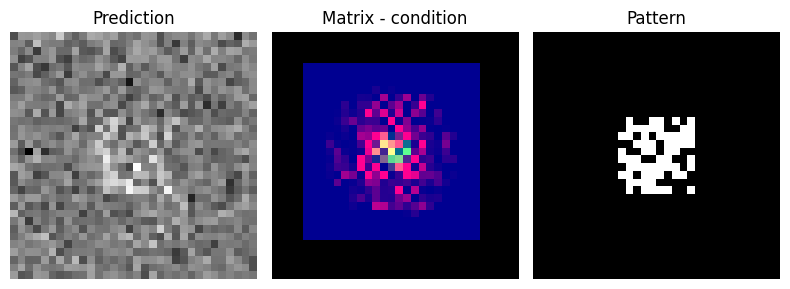


791it [01:12, 10.56it/s]
794it [01:12, 13.08it/s]
797it [01:12, 15.56it/s]
800it [01:13, 17.62it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


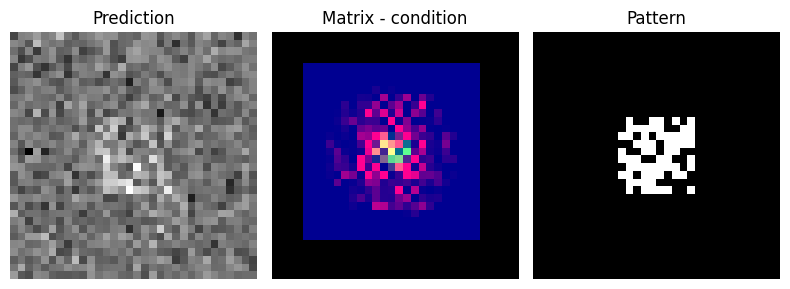


803it [01:13, 10.72it/s]
807it [01:13, 14.10it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


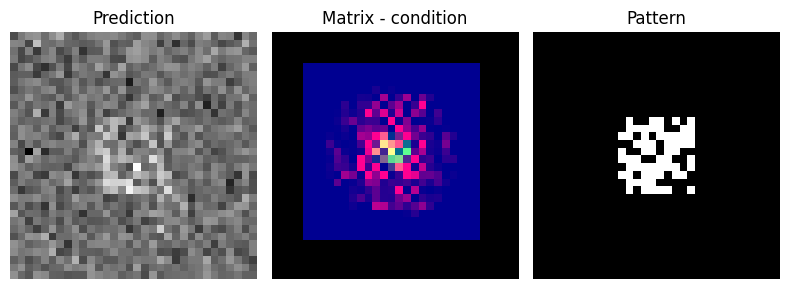


811it [01:14, 11.14it/s]
814it [01:14, 13.13it/s]
818it [01:14, 16.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


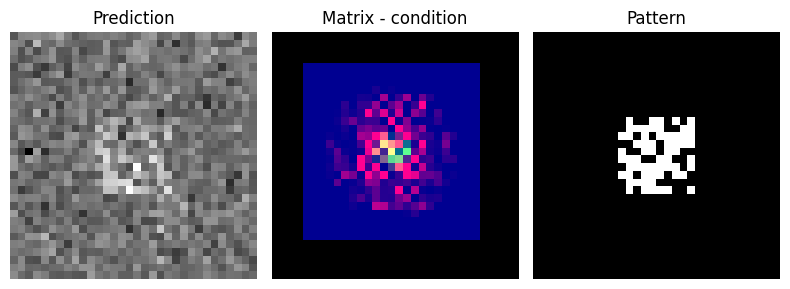


821it [01:15, 11.07it/s]
824it [01:15, 13.39it/s]
827it [01:15, 15.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


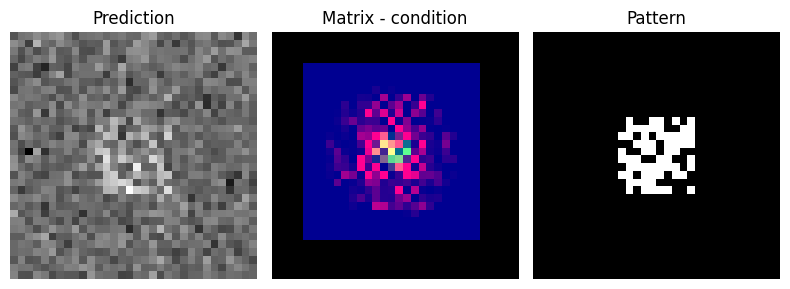


831it [01:15, 11.98it/s]
834it [01:15, 14.07it/s]
838it [01:15, 17.41it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


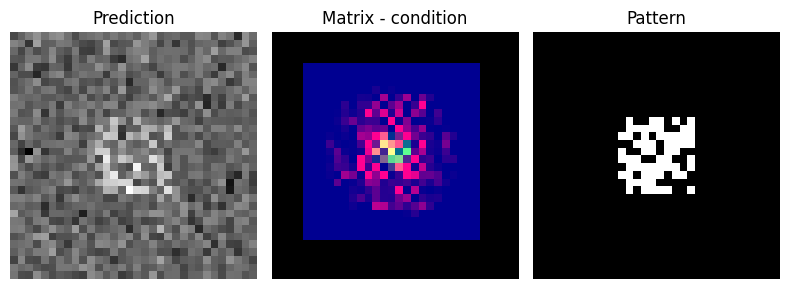


841it [01:16, 11.35it/s]
844it [01:16, 13.58it/s]
847it [01:16, 16.05it/s]
850it [01:16, 18.36it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


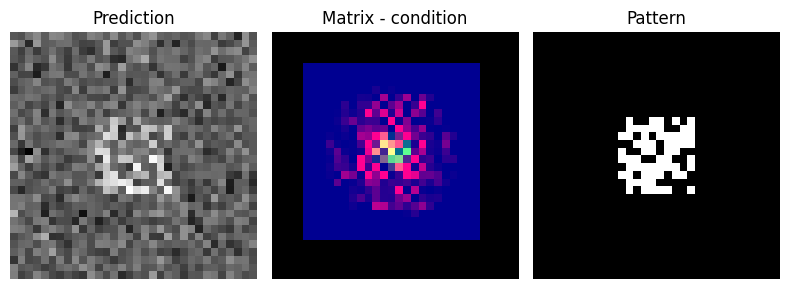


853it [01:17, 12.12it/s]
856it [01:17, 14.53it/s]
860it [01:17, 18.38it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


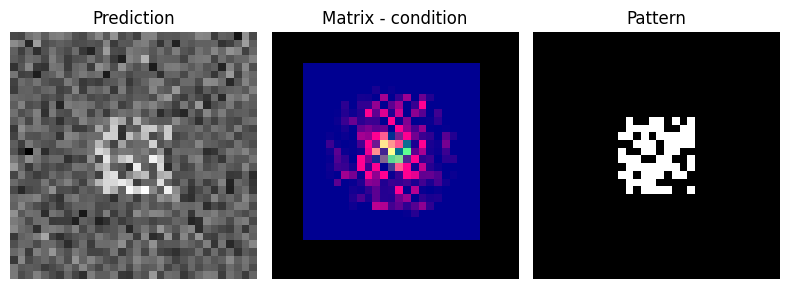


863it [01:17, 13.79it/s]
867it [01:17, 17.40it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


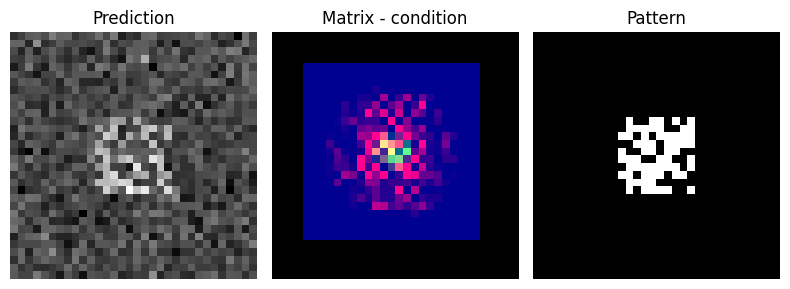


871it [01:18, 13.91it/s]
874it [01:18, 16.08it/s]
878it [01:18, 19.65it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


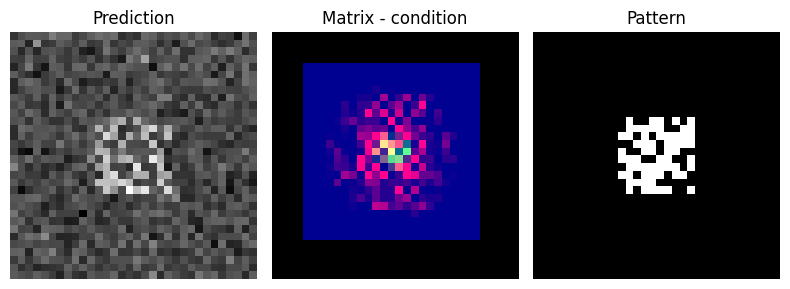


881it [01:18, 14.21it/s]
885it [01:19, 17.50it/s]
889it [01:19, 20.80it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


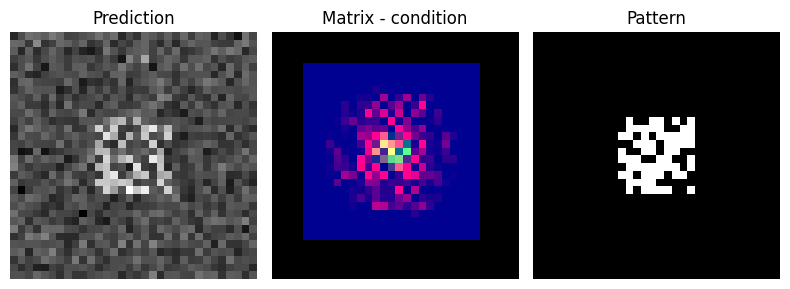


892it [01:19, 14.92it/s]
896it [01:19, 18.50it/s]
900it [01:19, 21.88it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


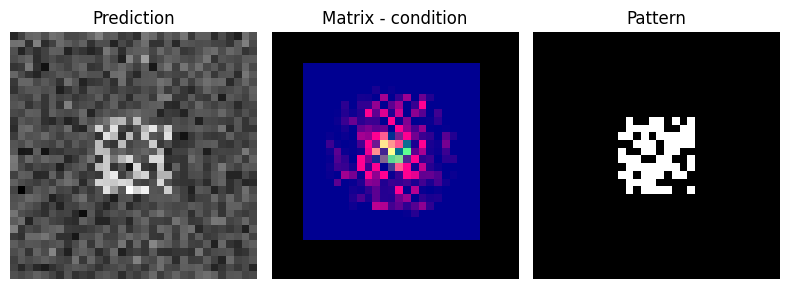


903it [01:20, 15.27it/s]
907it [01:20, 18.75it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


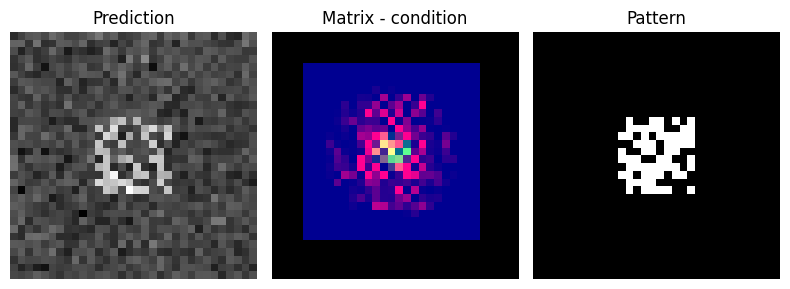


911it [01:20, 14.69it/s]
915it [01:20, 17.88it/s]
919it [01:20, 21.12it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


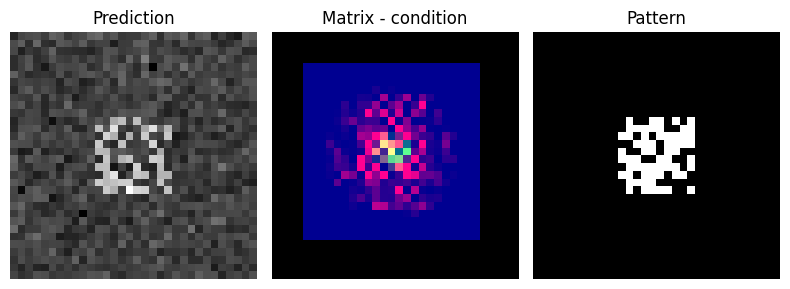


922it [01:21, 14.91it/s]
926it [01:21, 18.12it/s]
929it [01:21, 20.04it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


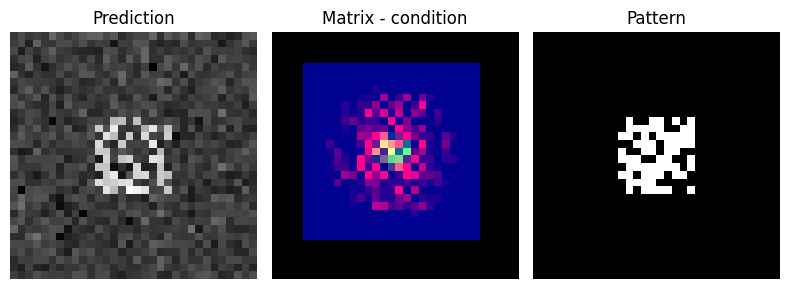


932it [01:21, 14.72it/s]
936it [01:21, 18.32it/s]
940it [01:22, 21.51it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


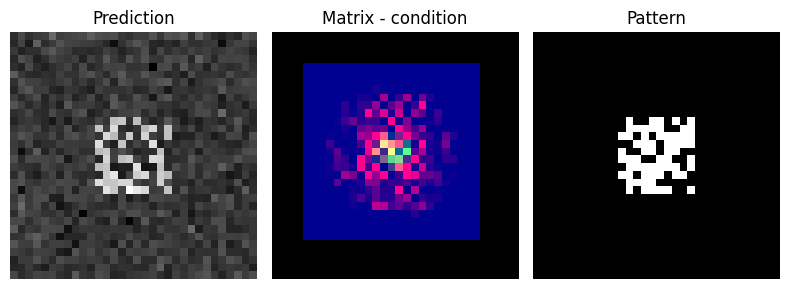


943it [01:22, 14.63it/s]
946it [01:22, 16.90it/s]
950it [01:22, 20.54it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


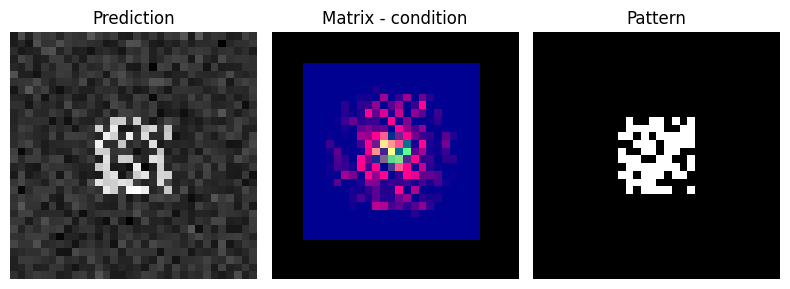


953it [01:23,  8.23it/s]
957it [01:23, 11.13it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


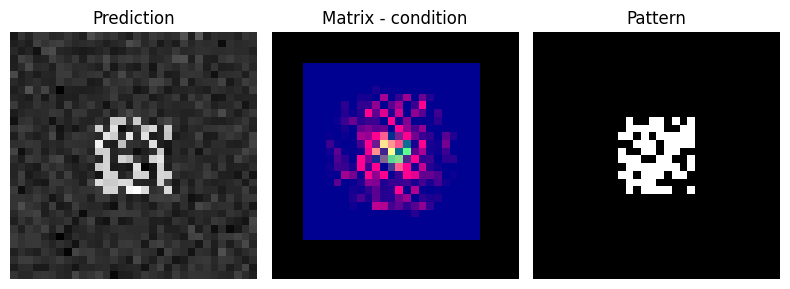


961it [01:24, 10.92it/s]
964it [01:24, 13.05it/s]
968it [01:24, 16.43it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


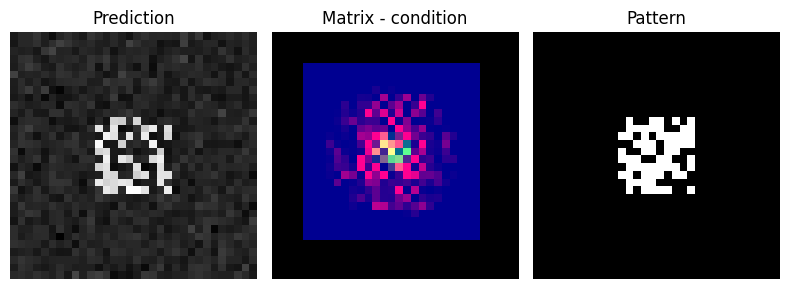


971it [01:24, 12.91it/s]
975it [01:24, 16.28it/s]
979it [01:24, 19.38it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


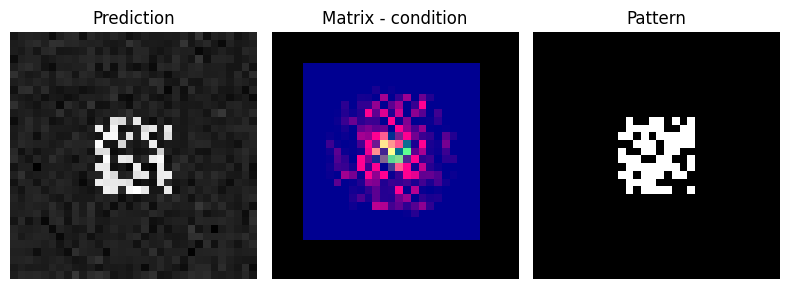


982it [01:25, 13.97it/s]
986it [01:25, 17.24it/s]
989it [01:25, 19.36it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


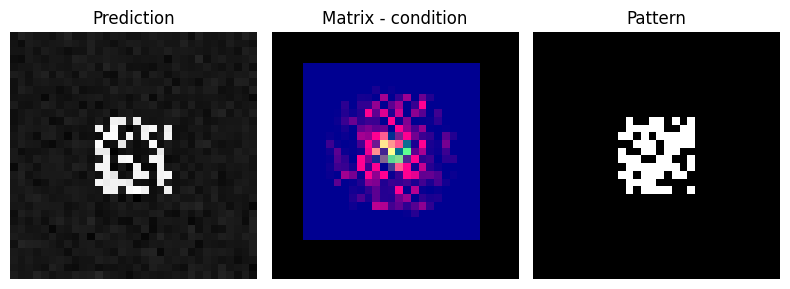


992it [01:25, 12.90it/s]
996it [01:26, 16.26it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


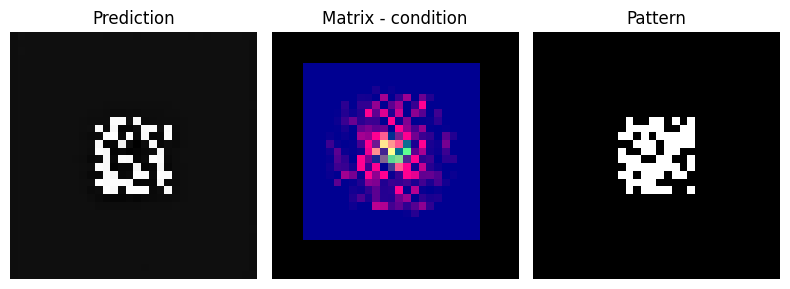


1000it [01:26, 11.56it/s]
  0%|          | 1/1150 [01:26<27:37:18, 86.54s/it]


In [ ]:
model = ClassConditionedUnet().to(device)
model_save_name ='trained_model_bs20.pt'
path = F"/content/drive/MyDrive/{model_save_name}"
model.load_state_dict(torch.load(path))
model.eval()
j = 0
with torch.no_grad():
  for matrix, pattern in tqdm(test_loader):
    if (j==1):
      break
    else:
      # Move data to the GPU if available
      matrix = matrix.to(device)
      pattern = pattern.to(device)
      initial_noise = torch.randn(20,1, 32, 32).to(device) # pattern size
      noise = initial_noise
      #print_matrix(noise,pattern)
      # Sampling loop
      for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

          # Get model pred
          with torch.no_grad():
              pred = model(noise, t, matrix.long())  # Again, note that we pass in our labels matrix

          # Update sample with step
          scheduler_output = noise_scheduler.step(pred, t, noise)
          noise = scheduler_output.prev_sample

          if i==0:
            print_matrix(noise,matrix,pattern)
          if i%10==0 and (i!=0):
            print_matrix(noise,matrix,pattern)
          if i == len(noise_scheduler.timesteps) - 1:
            print_matrix(noise,matrix,pattern)
      j= j+1


### ***Create a test loop***

In [ ]:
# Load the trained model
model = ClassConditionedUnet().to(device)
model_save_name ='trained_model_bs20.pt'

path = F"/content/drive/MyDrive/{model_save_name}"
model.load_state_dict(torch.load(path))
model.eval()  # Set the model to evaluation mode

# Initialize variables to accumulate counts
correct_predictions = 0
incorrect_predictions = 0
precisions = []
recalls = []

# Lists to store images that were correctly and incorrectly predicted
correctly_predicted_images = []
incorrectly_predicted_images = []

# Evaluation loop
with torch.no_grad():
    for matrix, pattern in tqdm(train_loader):
      # Move data to the GPU if available
      matrix = matrix.to(device)            # mapping between (-1,1)
      pattern = pattern.to(device)
      initial_noise = torch.randn(20,1, 32, 32).to(device) # pattern size
      noise = nitial_noise + pattern * torch.randn_like(pattern)
      noise = noise.to(device)
      #print_matrix(noise,pattern)
      # Sampling loop
      for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

          # Get model pred
          with torch.no_grad():
              pred = model(noise, t, matrix.long())  # Again, note that we pass in our labels matrix

          # Update sample with step
          scheduler_output = noise_scheduler.step(pred, t, noise)
          noise = scheduler_output.prev_sample

        # Check if each image in the batch is predicted correctly
      for i in range(noise.shape[0]):
          if np.all(noise[i] == pattern[i].cpu().numpy()):
              correct_predictions += 1
              correctly_predicted_images.append(pattern[i])
          else:
              incorrect_predictions += 1
              incorrectly_predicted_images.append(pattern[i])

      # Calculate precision and recall for the current image
      precision = precision_score(pattern[i].cpu().numpy().flatten(), numpy.array(noise[i].flatten()).astype(int))
      recall = recall_score(pattern[i].cpu().numpy().flatten(), numpy.array(noise[i].flatten()).astype(int))
      precisions.append(precision)
      recalls.append(recall)

# Calculate the overall image-level accuracy
total_images = correct_predictions + incorrect_predictions
image_level_accuracy = (correct_predictions / total_images) * 100
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

# Create a summary table
summary_data = {
    'Type': ['Correct Predictions', 'Incorrect Predictions', 'Overall Image-Level Accuracy',
             'Average Precision for Individual Images', 'Average Recall for Individual Images'],
    'Count': [correct_predictions, incorrect_predictions,f'{image_level_accuracy:.2f}%',f'{average_precision:.4f}',f'{average_recall:.4f}']
}

# Display the summary table
summary_df = pd.DataFrame(summary_data)
print(summary_df)
print(f'Overall Image-Level Accuracy: {image_level_accuracy:.2f}%')

# Plot a sample of the input, target, and predicted images
sample_idx = 0  # You can change this index to visualize different samples

input_image = noisy_step[sample_idx].cpu().numpy()
target_image = pattern[sample_idx].cpu().numpy()
pred_image = pred[sample_idx].cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Display the input image in the first subplot
axs[0].imshow(input_image[0], cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')  # Remove ticks and labels

# Display the target image in the second subplot
axs[1].imshow(target_image[0], cmap='gray')
axs[1].set_title('Target Image')
axs[1].axis('off')  # Remove ticks and labels

# Display the predicted image in the third subplot
axs[2].imshow(pred_image[0], cmap='gray')
axs[2].set_title('Predicted Image')
axs[2].axis('off')  # Remove ticks and labels

plt.show()

